In [1]:
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
from string import ascii_letters
import pandas as pd
from pandas.plotting import scatter_matrix
from sklearn.linear_model import LinearRegression

# Set styles
sns.set(style = "white")

In [858]:
# SUPPORT FUNCTIONS DATA PROCESSING
def collect_datasets(files = ['a', 'b'],
                     burn_in = 1000,
                     sort_ = True):
    dats = []
    for file_ in files:
        dats.append(pickle.load(open(file_ , 'rb')))

    dat_tmp_0 = []
    dat_tmp_1 = []
    for dat in dats:
        dat_tmp_0.append(dat[0])
        dat_tmp_1.append(dat[2])

    dat_total = [np.concatenate(dat_tmp_0, axis = 0), np.concatenate(dat_tmp_1, axis = 0)]


    # Sort by first column in parameters
    if sort_ == True:
        ind = np.argsort(dat_total[0][:, 0])
        dat_total[0] = dat_total[0][ind]
        dat_total[1] = dat_total[1][ind]

    # Calculate posterior means
    means = np.mean(dat_total[1][:, burn_in:, :], axis = (1))
    return (dat_total, means)

def get_r2_vec(estimates = [0, 0, 0],
               ground_truths = [0, 0, 0]):
    
    r2_vec = []
    for i in range(estimates.shape[1]):
        reg = LinearRegression().fit(np.asmatrix(estimates[:, i]).T, np.asmatrix(ground_truths[:, i]).T)
        r2_vec.append(str(round(reg.score(np.asmatrix(estimates[:, i]).T, np.asmatrix(ground_truths[:, i]).T), 2)))
    return r2_vec

In [859]:
# SUPPORT FUNCTIONS GRAPHS
def parameter_recovery_plot(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'], 
                            title = 'Parameter Recovery: ABC-NN',
                            ground_truths = [0, 0, 0],
                            estimates = [0, 0, 0],
                            r2_vec = [0, 0, 0],
                            cols = 3):
    
    rows = int(np.ceil(len(ax_titles) / cols))

    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    fig.suptitle(title, fontsize = 40)

    sns.despine(right = True)

    for i in range(estimates.shape[1]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        sns.regplot(ground_truths[:, i], estimates[:, i], 
                    color = 'black', 
                    marker =  '+',
                    ax = ax[row_tmp, col_tmp],
                    scatter_kws = {'s': 120, 'alpha': 0.5})
        ax[row_tmp, col_tmp].text(0.7, 0.1, '$R^2$: ' + r2_vec[i], 
                                  transform = ax[row_tmp, col_tmp].transAxes, 
                                  fontsize = 20)
        ax[row_tmp, col_tmp].set_xlabel(ax_titles[i] + ' - ground truth', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_ylabel(ax_titles[i] + ' - posterior mean', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 24)

    for i in range(estimates.shape[1], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    plt.setp(ax, yticks = [])
    return plt.show()


def trace_plots(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
                param_lims = [(-2, 2), (0.5, 2), (0.3,0.7), (0.0, 1.0), (0.0, 1.4)],
                title = 'Trace Plots',
                posterior_samples = [0, 0, 0],
                ground_truths = [0, 0, 0],
                trace_id = 1,
                cols = 3):
    
    T = posterior_samples.shape[1]
    rows = int(np.ceil(len(ax_titles) / cols))

    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, 
                           cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)

    sns.despine(right = True)

    for i in range(posterior_samples.shape[2]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        sns.lineplot(data = posterior_samples[trace_id, :, i], 
                     color = 'black', 
                     ax = ax[row_tmp, col_tmp])
        ax[row_tmp, col_tmp].axhline(y = ground_truths[trace_id, i], color = 'red')
        ax[row_tmp, col_tmp].set_ylim(param_lims[i])
        ax[row_tmp, col_tmp].set_title(ax_titles[i], fontsize = 24)
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 24)
        ax[row_tmp, col_tmp].tick_params(axis = "y", 
                                         labelsize = 24)

    for i in range(posterior_samples.shape[2], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    #plt.setp(ax, yticks = [])
    plt.tight_layout()
    
    
def correlation_hist_plot(data = [0, 0, 0],
                          ax_titles = ['v', 'a', 'w', 'ndt', 'angle']): 
    
    # Plot histograms of correlations between parameters
    # Get array of correlation matrices for all plots
    corr_mat_array = np.zeros((data[1].shape[0], data[0].shape[1], data[0].shape[1]))   
    for i in range(data[1].shape[0]):
        corr_mat_array[i, :, :] = pd.DataFrame(data[1][i, : ,:], columns = ax_titles).corr()

    grid_size = corr_mat_array.shape[2] - 1

    fig, ax = plt.subplots(grid_size, grid_size, 
                           figsize = (20, 20), 
                           sharex = True, 
                           sharey = True)

    fig.suptitle('Posterior Correlations Between Parameters', fontsize = 40)
    grayscale_map = plt.get_cmap('YlGn')

    normalized_params = np.zeros(data[0].shape)
    for i in range(corr_mat_array.shape[1]):
        normalized_params[:, i] = (data[0][:, i] - np.min(data[0][:, i])) \
        / (np.max(data[0][:, i]) - np.min(data[0][:, i]))


    for i in range(grid_size):
        for j in range(grid_size):
            if j > i:
                ax[i, j].axis('off')
            else:
                sns.distplot(corr_mat_array[:, - (i + 2), - (j + 1)], 
                             bins = 20,
                             color = 'black',
                             norm_hist = True,
                             kde = True,
                             rug = True,
                             rug_kws = {"c": grayscale_map(normalized_params[:,  - (j + 1)]), 
                                        'alpha': 0.3},
                             ax = ax[i, j])

                if j == 0:
                    ax[i, j].set_ylabel(ax_titles[- (i + 2)], 
                                        fontsize = 24);
                    ax[i, j].tick_params(axis = "y", 
                                         labelsize = 20)
                if i == (grid_size - 1):
                    ax[i, j].set_xlabel(ax_titles[- (j + 1)], 
                                        fontsize = 24);
                    ax[i, j].tick_params(axis = "x", 
                                         labelsize = 20)

    ax[i, j].set_yticks(ax[i, j].get_yticks()[::2])                
    #plt.tight_layout()
    plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    
def get_posterior_variances(data = [0, 0, 0],
                            ax_titles = ['v', 'a', 'w', 'ndt']):
    
    # MLP
    var_data = np.array(np.zeros((data[0].shape[0], data[0].shape[1])))
    
    for i in range(data[0].shape[0]):
        var_data[i, :] = np.diag(pd.DataFrame(data[1][i, : ,:], columns = ax_titles).cov())
    return var_data

    
def posterior_variance_comparison_hist(var_data_1 = [],
                                       var_data_2 = [],
                                       var_data_1_title = '..',
                                       var_data_2_title = '..',
                                       ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
                                       cols = 3):  

    rows = int(np.ceil(len(ax_titles) / cols))

    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = True)
    fig.suptitle('Posterior variance: ' + var_data_1_title + ' vs. ' + var_data_2_title + ' (Histogram)', 
                 fontsize = 40)
    sns.despine(right = True)

    x_title = '$\ln \sigma^2_{' + var_data_1_title + '} - \ln \sigma^2_{' + var_data_2_title + '}$'

    for i in range(var_data_1.shape[1]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)

        sns.distplot(np.log((var_data_1[:, i])) -  np.log((var_data_2[:, i])), 
                     bins = 20,
                     color = 'black',
                     norm_hist = True,
                     kde = False,
                     rug = False,
                     #rug_kws = {"c": grayscale_map(dat_total[0][:, j]), 'alpha': 0.3},
                     ax = ax[row_tmp, col_tmp])

        ax[row_tmp, col_tmp].set_xlabel(x_title, 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 24)
        ax[row_tmp, col_tmp].tick_params(axis = "y",
                                         labelsize = 24)
        ax[row_tmp, col_tmp].set_title(ax_titles[i], fontsize = 24)

    for i in range(var_data_1.shape[1], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    #plt.show()
    

def posterior_variance_comparison_reg(var_data_1 = [],
                                      var_data_2 = [],
                                      params = [], # need params here because we used normalize params to color graphs
                                      var_data_1_title = '..',
                                      var_data_2_title = '..',
                                      ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
                                      cols = 3):  
    # 
    rows = int(np.ceil(len(ax_titles) / cols))

    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)

    fig.suptitle('Posterior variance: ' + var_data_1_title + ' vs. ' + var_data_2_title + ' (Histogram)', 
                 fontsize = 40)
    sns.despine(right = True)

    x_title = '$\ln \sigma^2_{' + var_data_1_title + '} - \ln \sigma^2_{' + var_data_2_title + '}$'

    # Get normalized parameters for coloring purposes
    normalized_params = np.zeros(params.shape)
    for i in range(params.shape[1]):
        normalized_params[:, i] = (params[:, i] - np.min(params[:, i])) \
        / (np.max(params[:, i]) - np.min(params[:, i]))

    for i in range(params.shape[1]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        sns.regplot(np.log(var_data_1[:, i]), np.log(var_data_2[:, i]),
                    marker =  '+',
                    ax = ax[row_tmp, col_tmp],
                    scatter_kws = {'s': 120, 
                                   'alpha': 0.5,
                                   'color': grayscale_map(normalized_params[:, i])},
                    line_kws = {'color': 'black'})

        xlabel_tmp = '$ \ln(\sigma^2_{' +  var_data_1_title  + '})$: ' + ax_titles[i]
        ylabel_tmp = '$ \ln(\sigma^2_{' +  var_data_2_title  + '})$: ' + ax_titles[i]
        
        ax[row_tmp, col_tmp].set_xlabel(xlabel_tmp, 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].set_ylabel(ylabel_tmp, 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 24)
        ax[row_tmp, col_tmp].tick_params(axis = "y", 
                                         labelsize = 24)

    for i in range(params.shape[1], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    #plt.setp(ax, yticks = [])
    plt.tight_layout(rect = [0, 0.03, 1, 0.9])
    #plt.show()

In [840]:
# REMAINING META

# DDM Angle
ax_titles_angle = ['v', 'a', 'w', 'ndt', 'angle']
param_lims_angle = [(-2, 2), (0.5, 2), (0.3,0.7), (0.0, 1.0), (0.0, 1.4)]

# DDM
ax_titles_ddm = ['v', 'a', 'w', 'ndt']
param_lims_ddm = [(-2, 2), (0.5, 2), (0.3,0.7), (0.0, 1.0)]

# LBA
ax_titles_lba = ['v_0', 'v_1', 'A', 'b', 's', 'ndt']
param_lims_lba = [(1, 2), (1, 2), (0, 1), (1.5, 3), (0.1, 0.2), (0, 1)]

# WEIBULL 
ax_titles_weibull = ['v', 'a', 'w', 'ndt', 'alpha', 'beta']

In [841]:
# META PARAMS: KDE 
method_comparison_folder = "/media/data_cifs/afengler/data/kde/weibull_cdf/method_comparison/"
#file_signature  = 'kde_sim_test_ndt'
file_signature = 'post_samp'
burn_in = 1000
file_signature_len = len(file_signature)
files = os.listdir(method_comparison_folder)
files = [method_comparison_folder + file_ for file_ in files if file_[:file_signature_len] == file_signature]

dat_total, means = collect_datasets(files = files,
                                    burn_in = 2500,
                                    sort_ = True)

r2_vec = get_r2_vec(estimates = means, 
                   ground_truths = dat_total[0])

mlp_var = get_posterior_variances(data = dat_total, 
                                  ax_titles = ax_titles_weibull)

In [694]:
# META PARAMS: ANALYTIC
method_comparison_folder = "/media/data_cifs/afengler/data/analytic/ddm/method_comparison/"
file_signature  = 'analytic_sim_test_ndt'
file_signature_len = len(file_signature)
files = os.listdir(method_comparison_folder)
files = [method_comparison_folder + file_ for file_ in files if file_[:file_signature_len] == file_signature]

dat_total_ddm, means_ddm = collect_datasets(files = files,
                                            burn_in = 2500,
                                            sort_ = True)

r2_vec_ddm = get_r2_vec(estimates = means_ddm,
                        ground_truths = dat_total_ddm[0])

analytic_var = get_posterior_variances(data = dat_total_ddm,
                                       ax_titles = ax_titles_ddm)

In [705]:
# META PARAMS: FCN
#deep_inference_file = 'deep_inference_sim_test_ndt_7faf6168-eeaf-11e9-bec8-c72c932a223f.pickle' 
deep_inference_file = 'deep_inference_sim_test_ndt_7d9bfe92-ee08-11e9-a7ea-e3f6145c7f37.pickle'
method_comparison_folder = "/media/data_cifs/afengler/data/kde/ddm/method_comparison/"
dat_total_fcn = pickle.load(open(method_comparison_folder + deep_inference_file, 'rb'))

ind = np.argsort(dat_total_fcn[0][:, 0])
dat_total_fcn[0][:] = dat_total_fcn[0][ind]
dat_total_fcn[1][:, :] = dat_total_fcn[1][ind]
dat_total_fcn[2][:] = dat_total_fcn[2][ind]

# FCN
deep_inference_var = fcn_dat_total[2][:, int(fcn_dat_total[2].shape[1] / 2):]

r2_vec_fcn = get_r2_vec(estimates = dat_total_fcn[2][:, :int(dat_total_fcn[2].shape[1] / 2)],
                        ground_truths = dat_total_fcn[0])

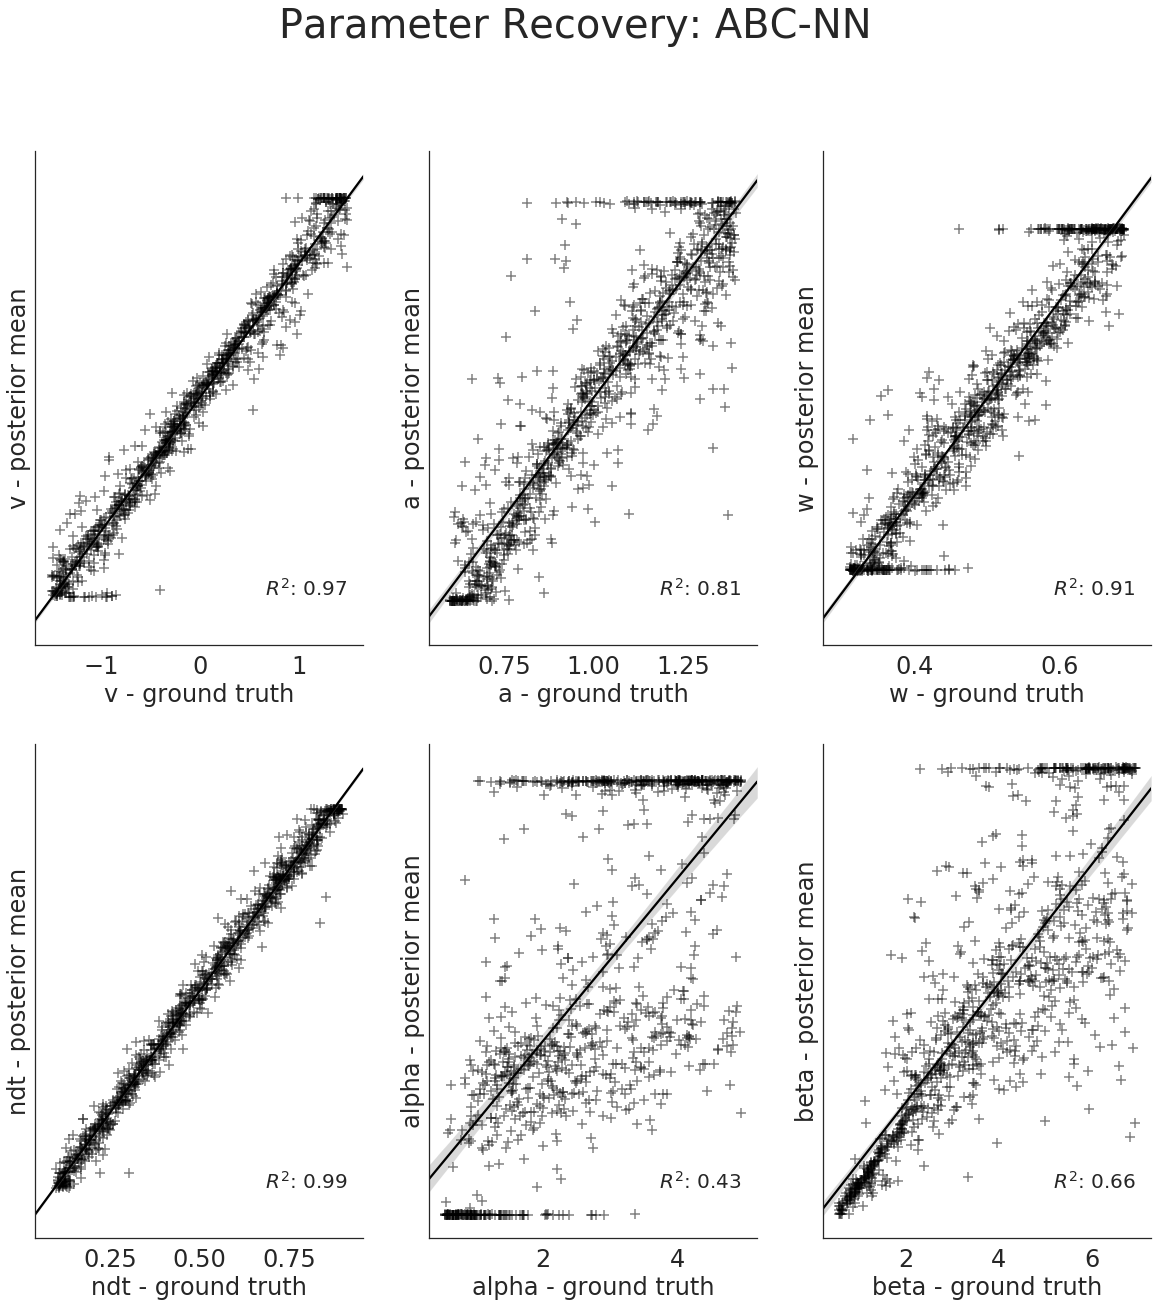

In [842]:
# PARAMETER RECOVERY PLOTS: KDE
parameter_recovery_plot(ax_titles = ax_titles_weibull,
                        title = 'Parameter Recovery: ABC-NN',
                        ground_truths = dat_total[0],
                        estimates = means,
                        r2_vec = r2_vec,
                        cols = 3)

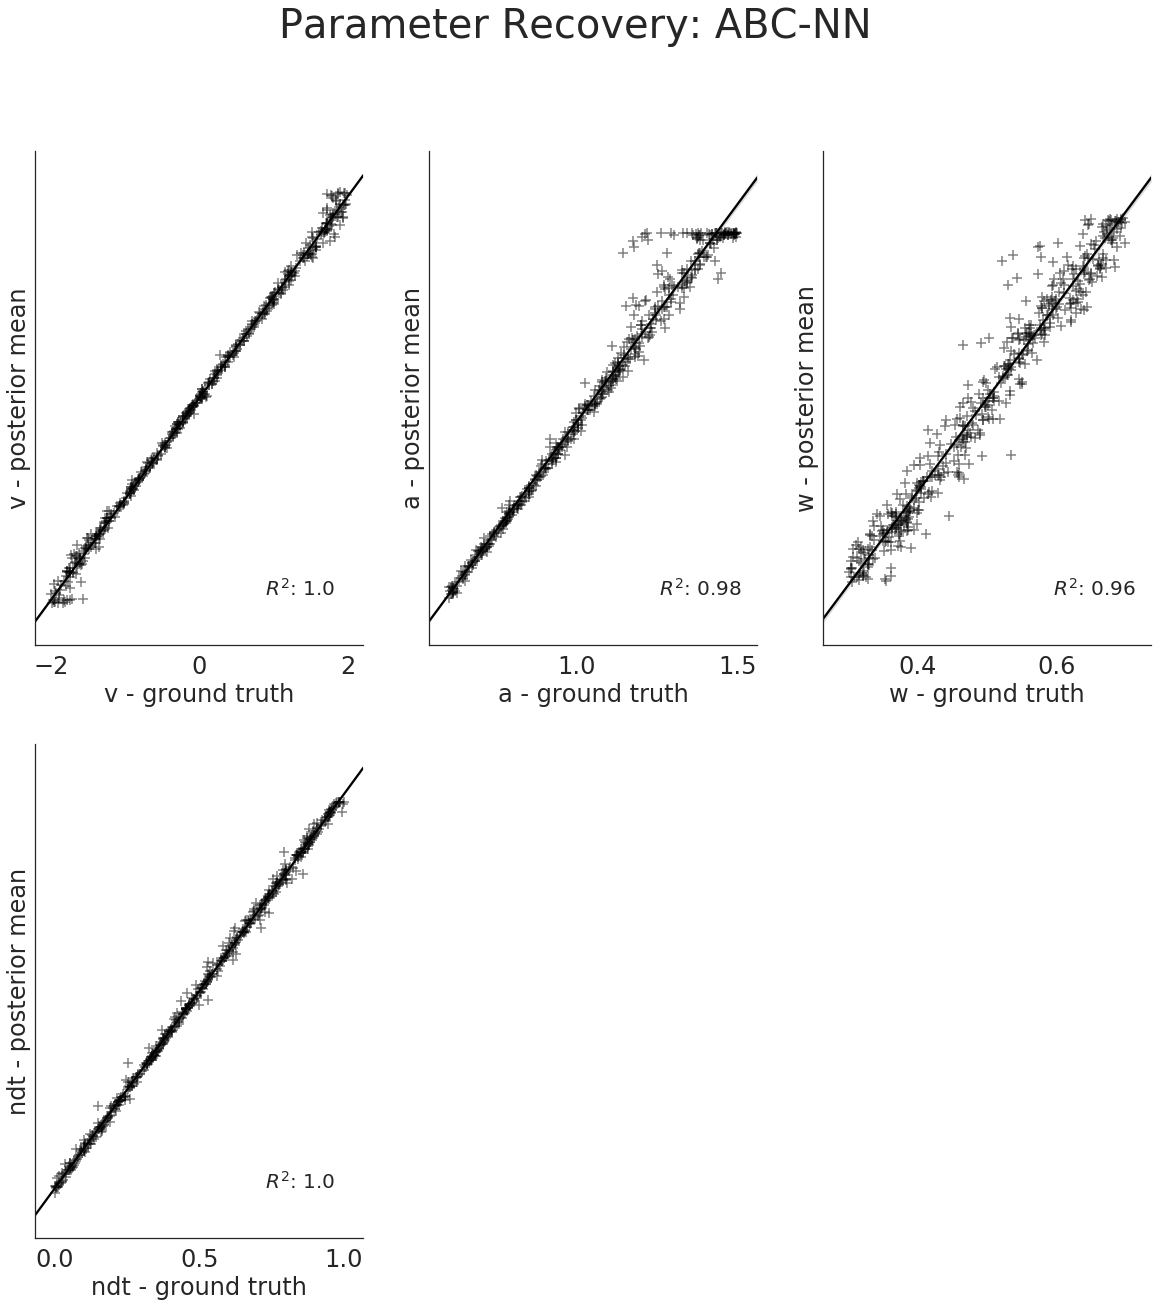

In [703]:
# PARAMETER RECOVERY PLOTS: ANALYTIC
parameter_recovery_plot(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
                        title = 'Parameter Recovery: ABC-NN',
                        ground_truths = dat_total_ddm[0],
                        estimates = means_ddm,
                        r2_vec = r2_vec_ddm,
                        cols = 3)

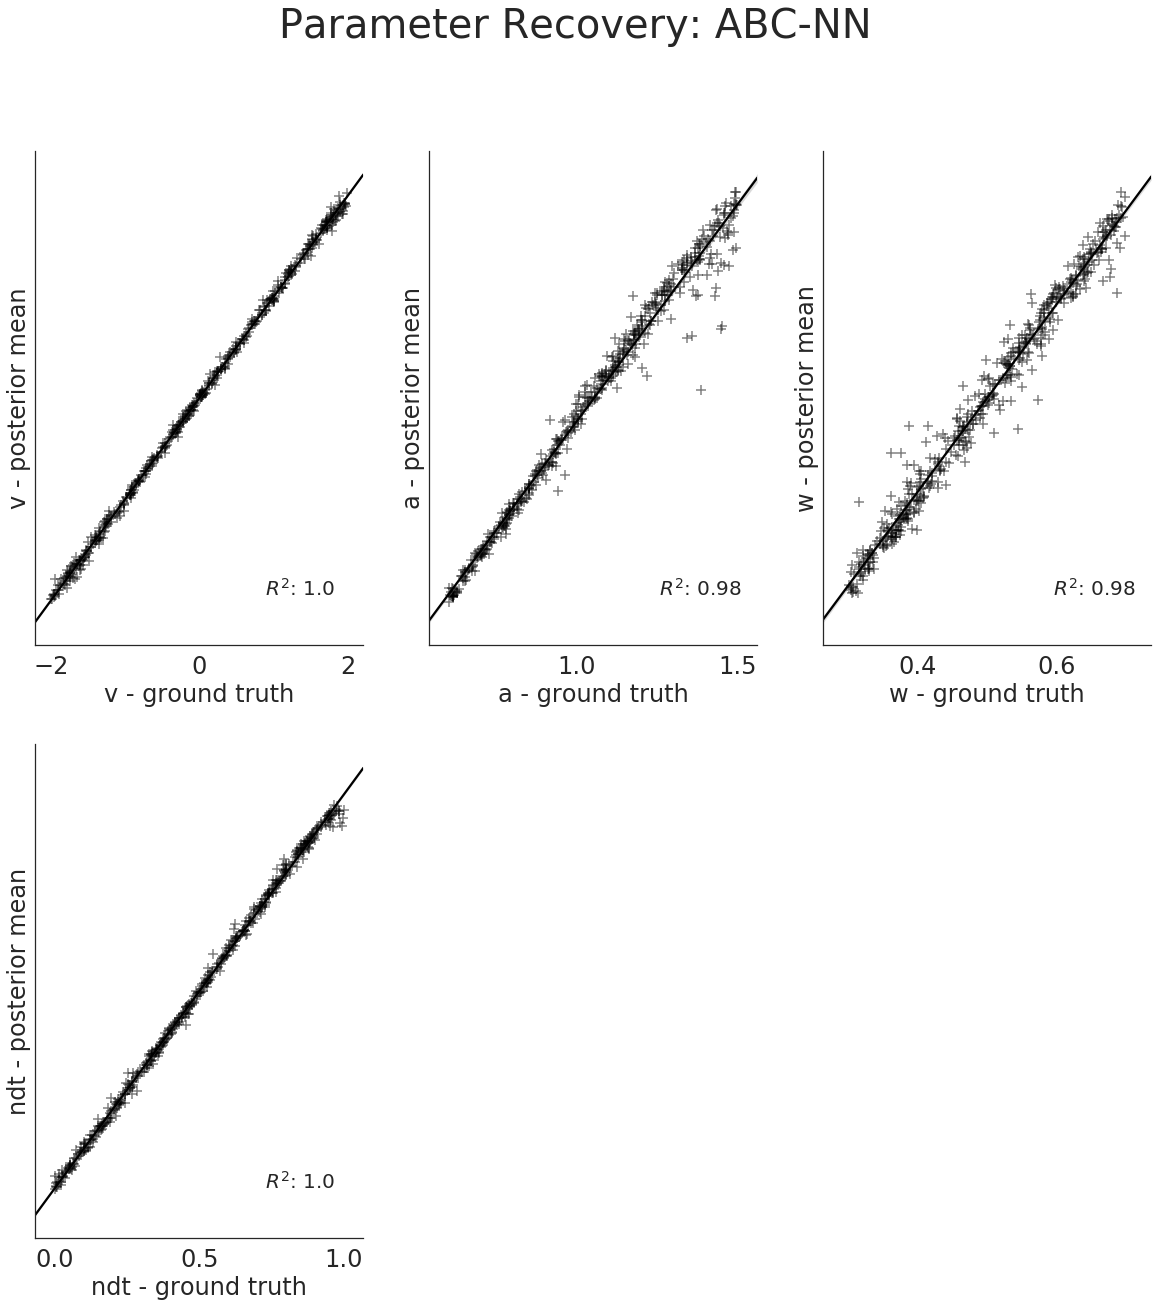

In [709]:
# PARAMETER RECOVERY PLOTS: ANALYTIC
parameter_recovery_plot(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
                        title = 'Parameter Recovery: ABC-NN',
                        ground_truths = dat_total_fcn[0],
                        estimates = dat_total_fcn[2][:, :int(dat_total_fcn[2].shape[1] / 2)],
                        r2_vec = r2_vec_fcn,
                        cols = 3)

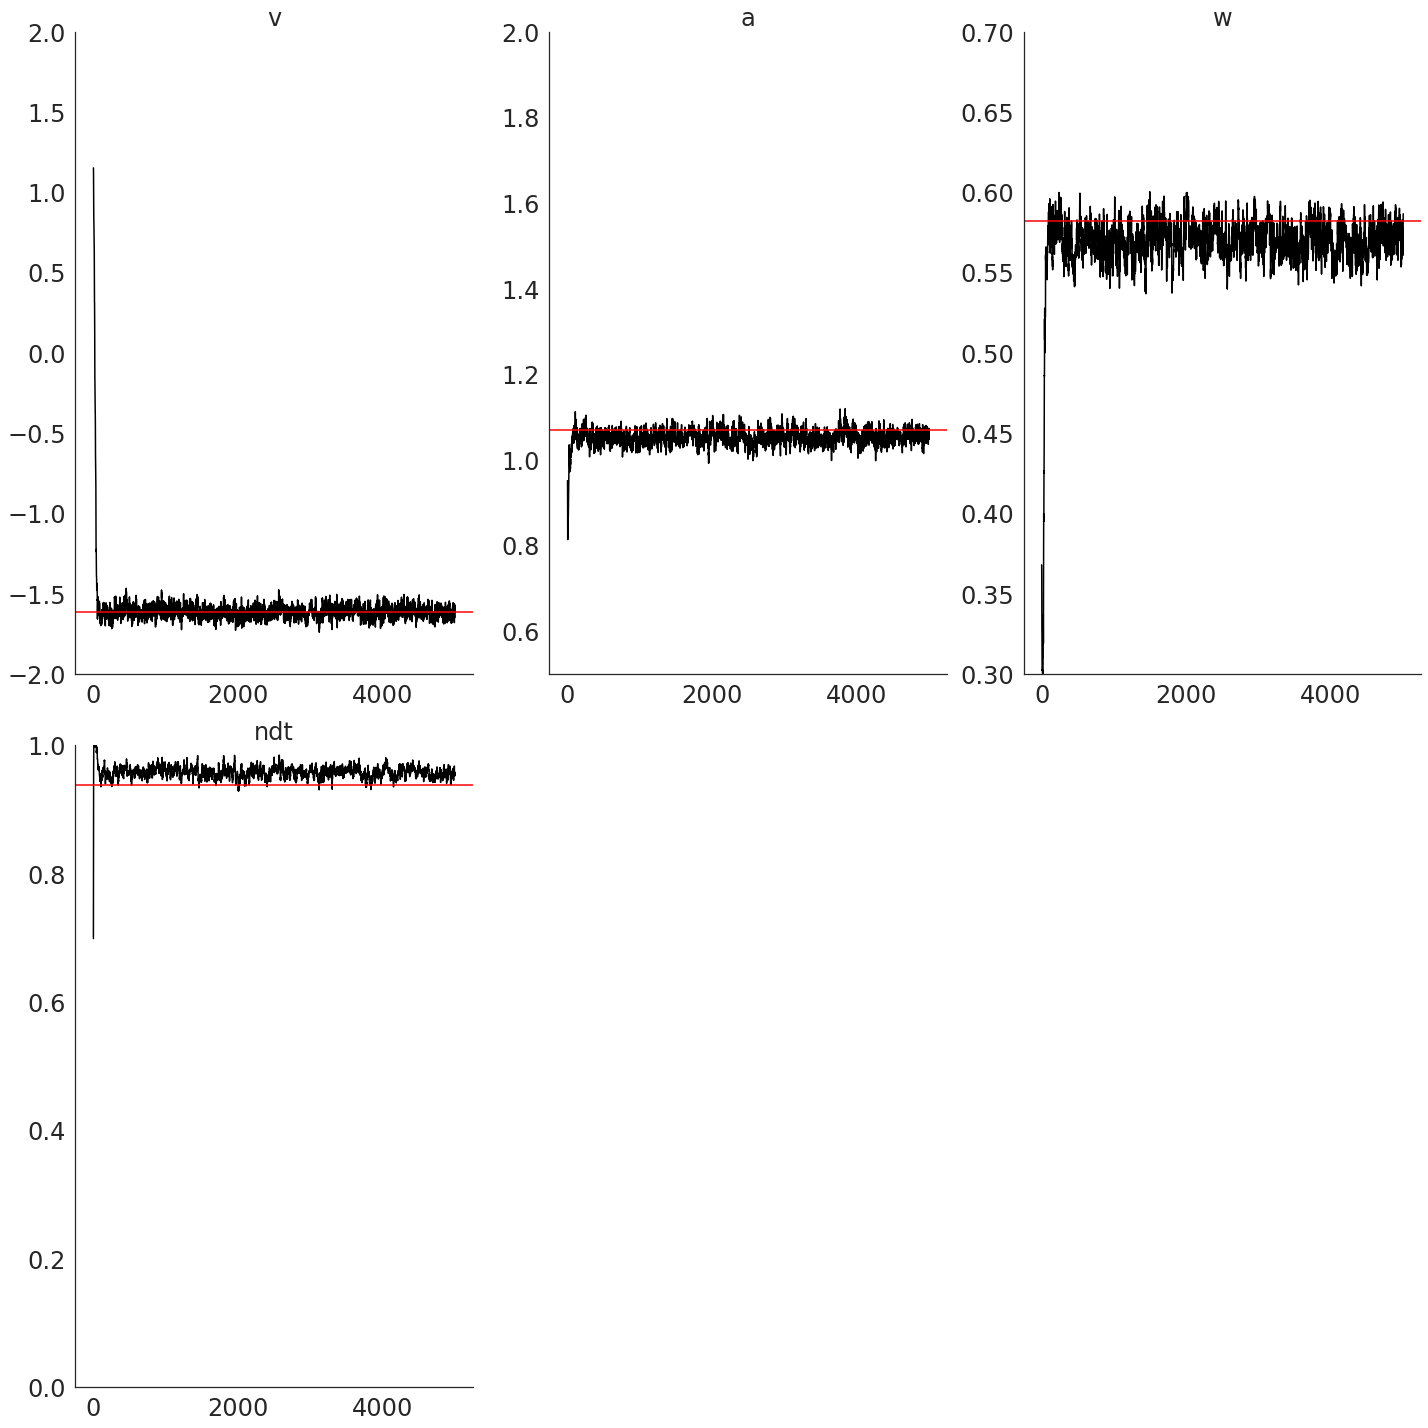

In [717]:
# TRACE PLOTS: KDE
trace_plots(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
            param_lims = [(-2, 2), (0.5, 2), (0.3, 0.7), (0.0, 1.0), (0.0, 1.4)],
            title = 'Trace Plots',
            posterior_samples = dat_total[1],
            ground_truths = dat_total[0],
            trace_id = 50,
            cols = 3)

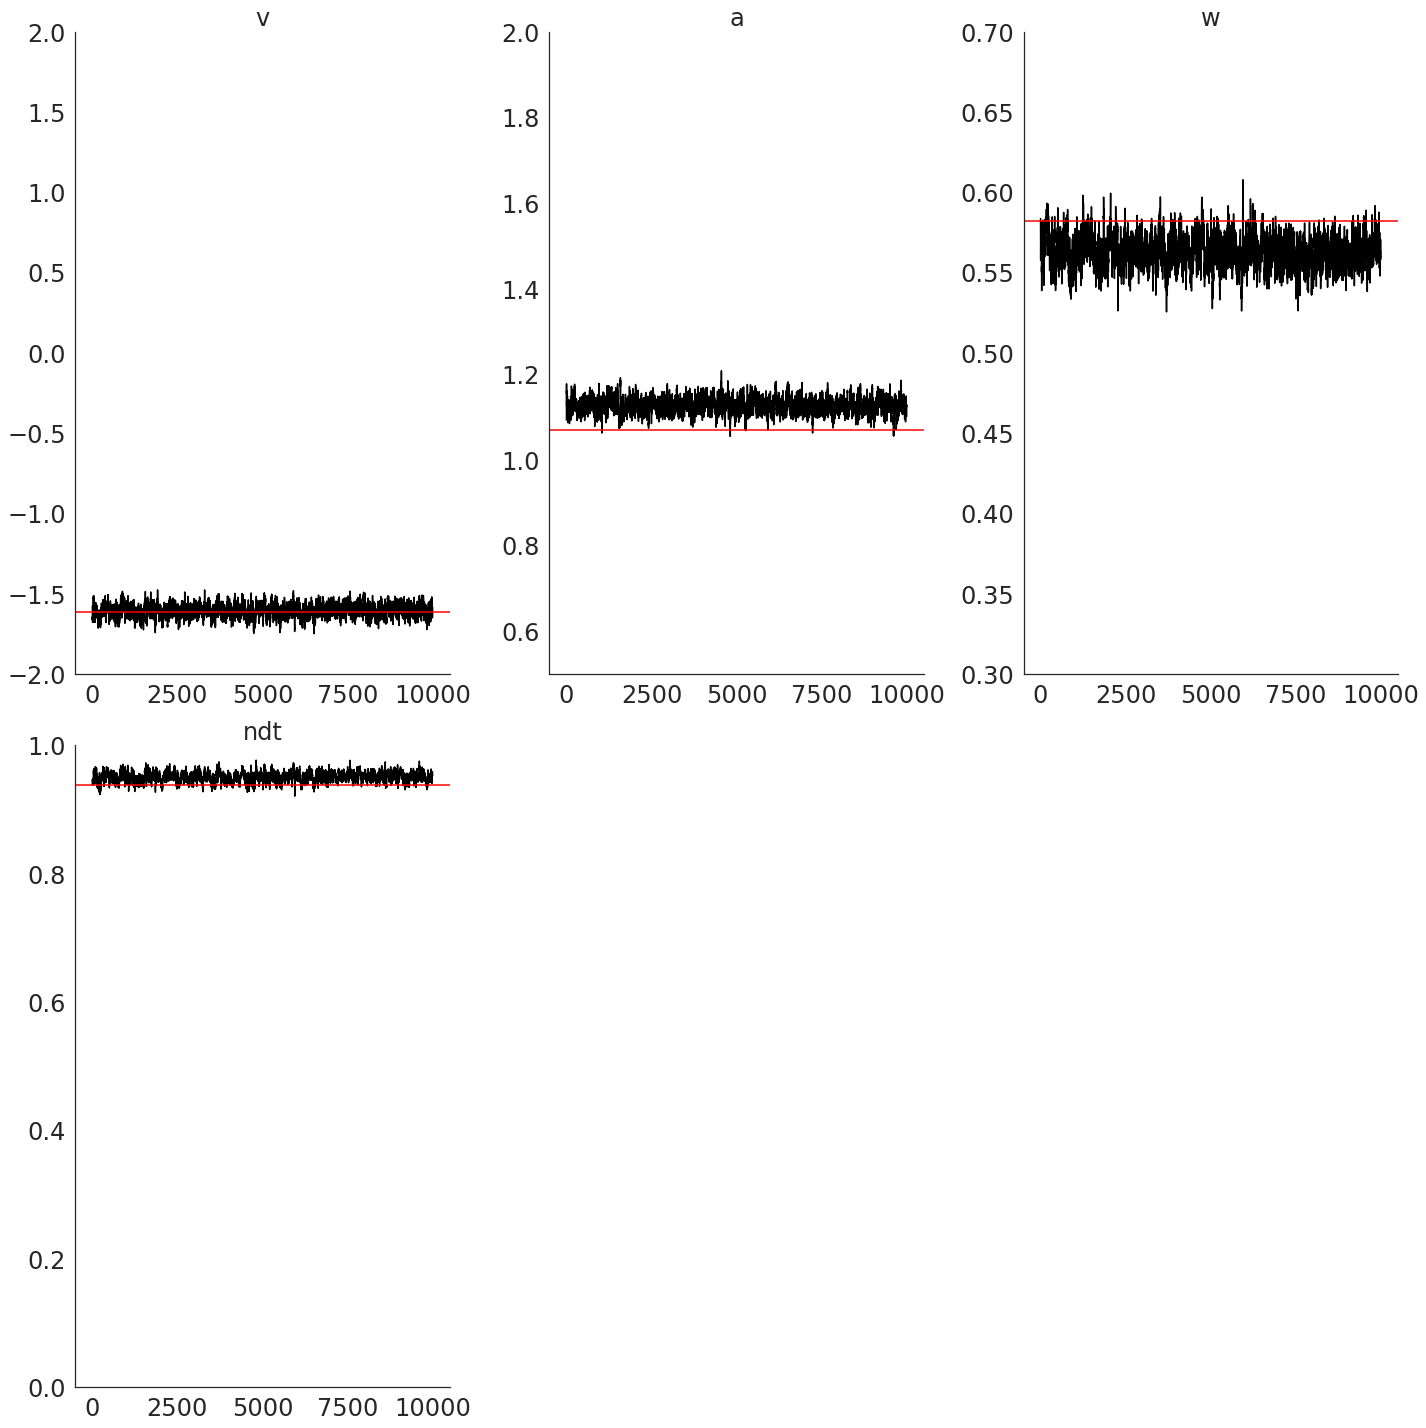

In [718]:
# TRACE PLOTS: ANALYTIC
trace_plots(ax_titles = ['v', 'a', 'w', 'ndt', 'angle'],
            param_lims = [(-2, 2), (0.5, 2), (0.3, 0.7), (0.0, 1.0), (0.0, 1.4)],
            title = 'Trace Plots',
            posterior_samples = dat_total_ddm[1],
            ground_truths = dat_total_ddm[0],
            trace_id = 50,
            cols = 3)

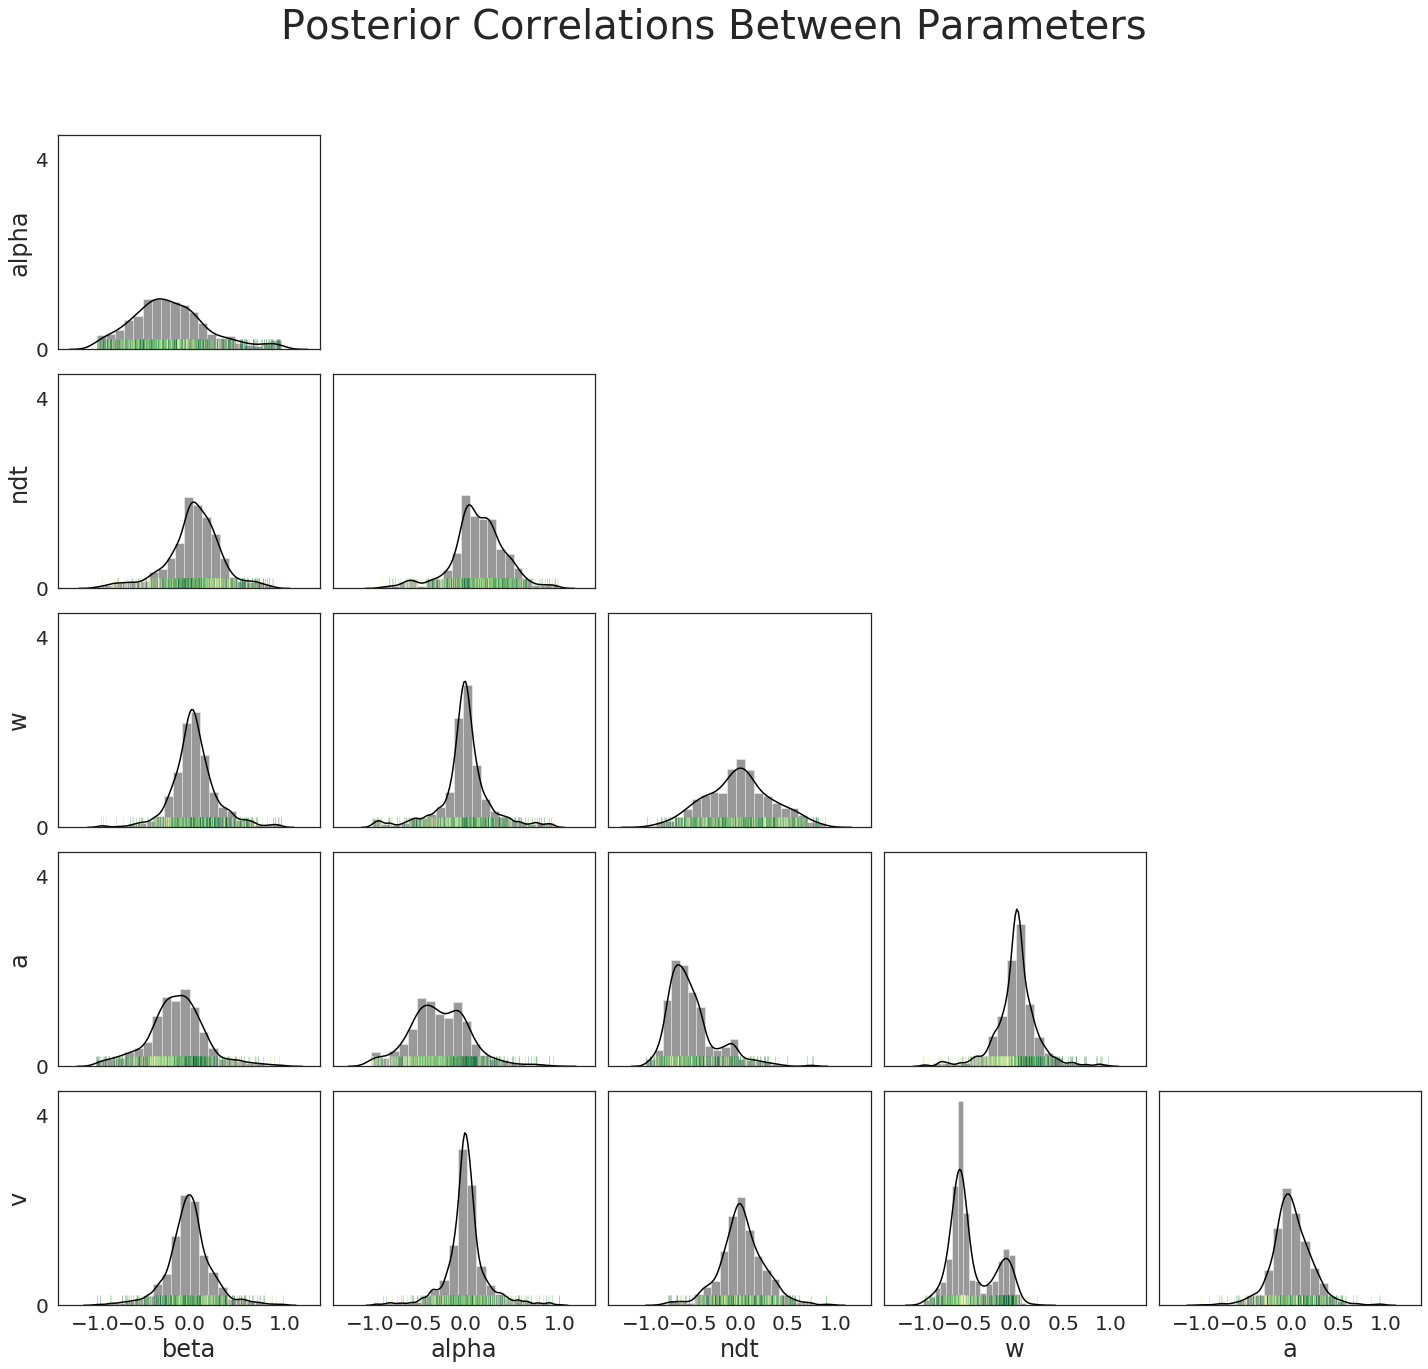

In [845]:
# Correlation Histograms: KDE
correlation_hist_plot(data = dat_total,
                      ax_titles = ax_titles_weibull)

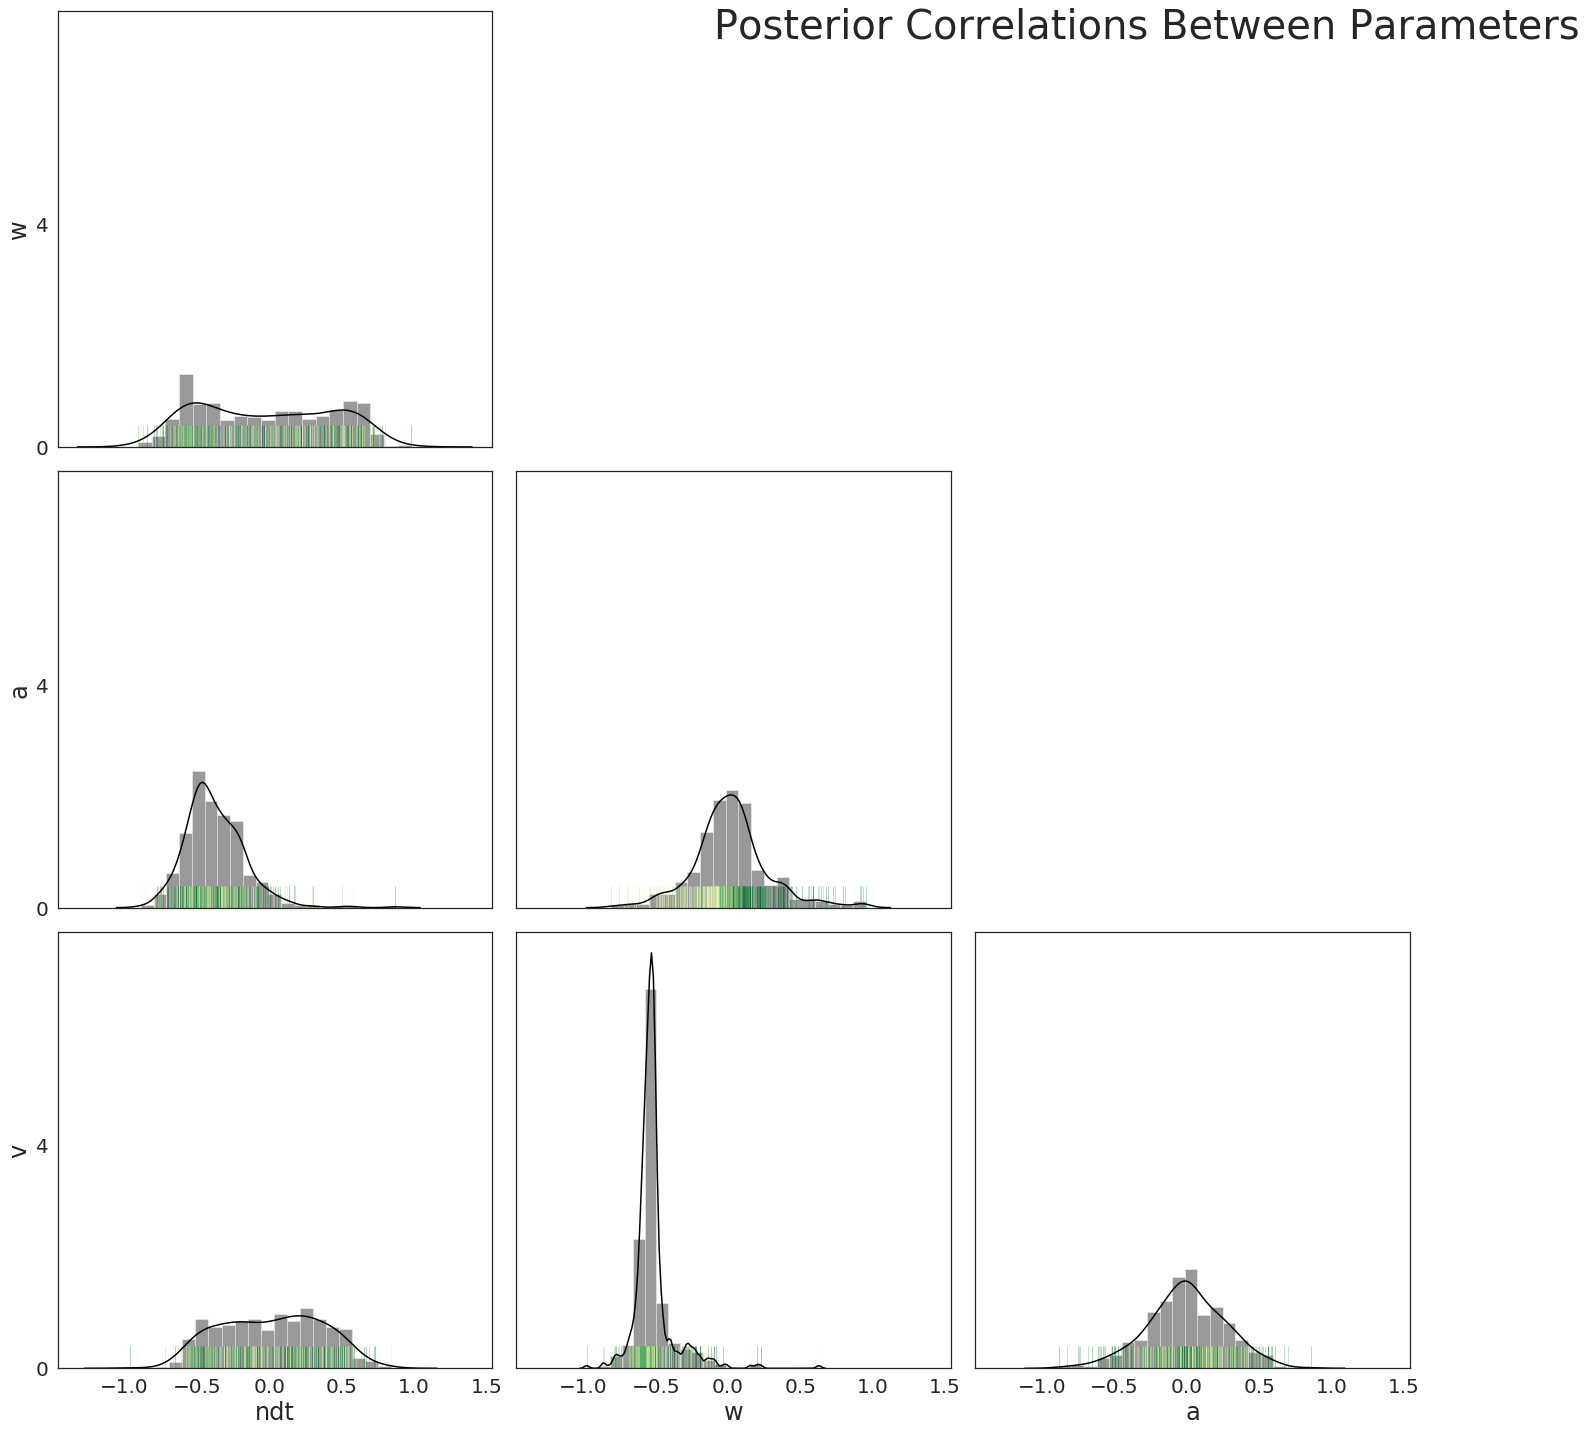

In [756]:
# Correlation Histograms: ANALYTIC
correlation_hist_plot(data = dat_total_ddm,
                      ax_titles = ax_titles_ddm)

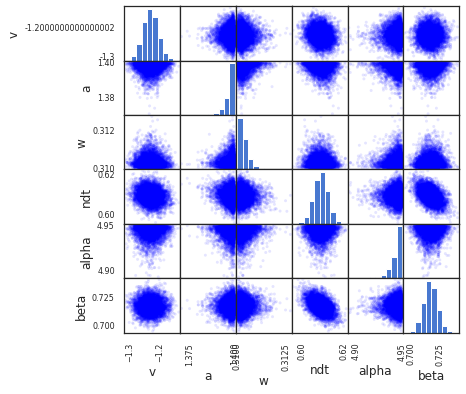

In [851]:
# Scatter matrix Analytical
scatter_matrix(pd.DataFrame(dat_total[1][37, 2500: ,:], columns = ax_titles_weibull), alpha = 0.1, figsize = (6, 6), color = 'blue')
plt.show()

In [852]:
dat_total[0][37]

array([-1.40800053,  0.95108056,  0.32100496,  0.67470776,  4.86023482,
        0.76347547])

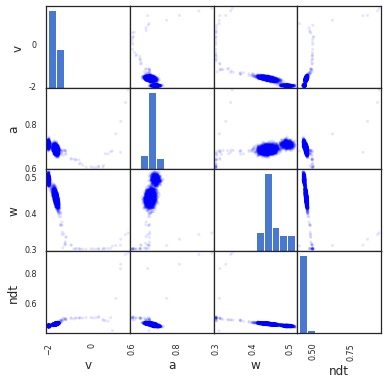

In [616]:
# Scatter matrix Analytical
scatter_matrix(pd.DataFrame(dat_total[1][36, : ,:], columns = ax_titles[:-1]), alpha = 0.1, figsize = (6, 6), color = 'blue')
plt.show()

ValueError: operands could not be broadcast together with shapes (1000,) (500,) 

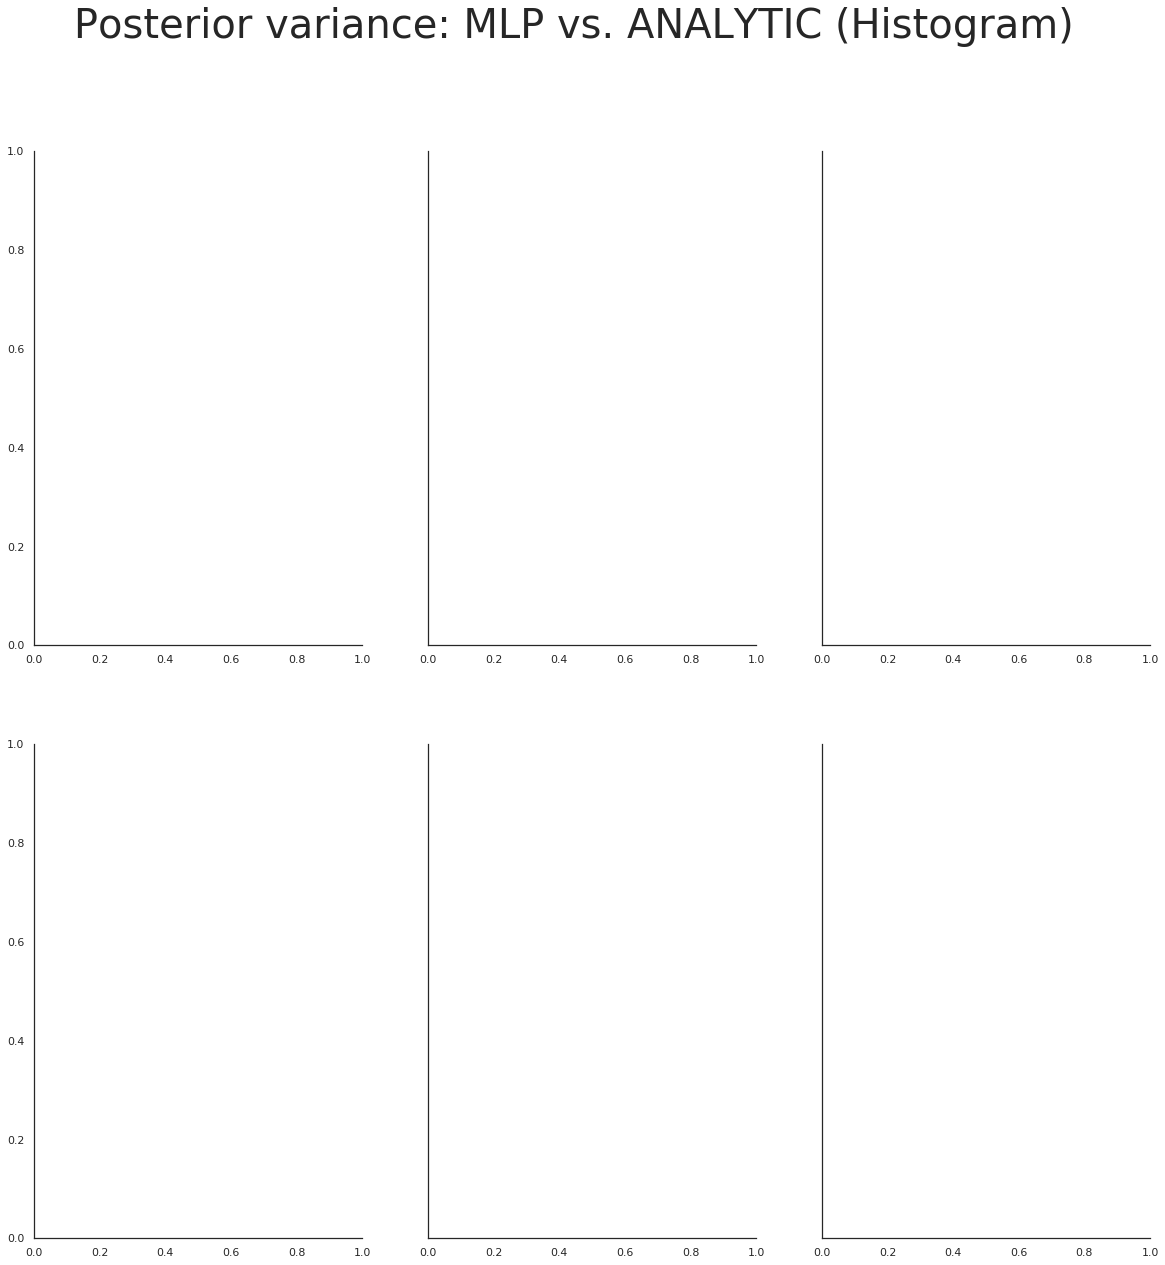

In [856]:
# Posterior variance Histograms: MLP vs. ANALYTIC
posterior_variance_comparison_hist(var_data_1 = mlp_var,
                                   var_data_2 = analytic_var,
                                   var_data_1_title = 'MLP',
                                   var_data_2_title = 'ANALYTIC',
                                   ax_titles = ax_titles_ddm)

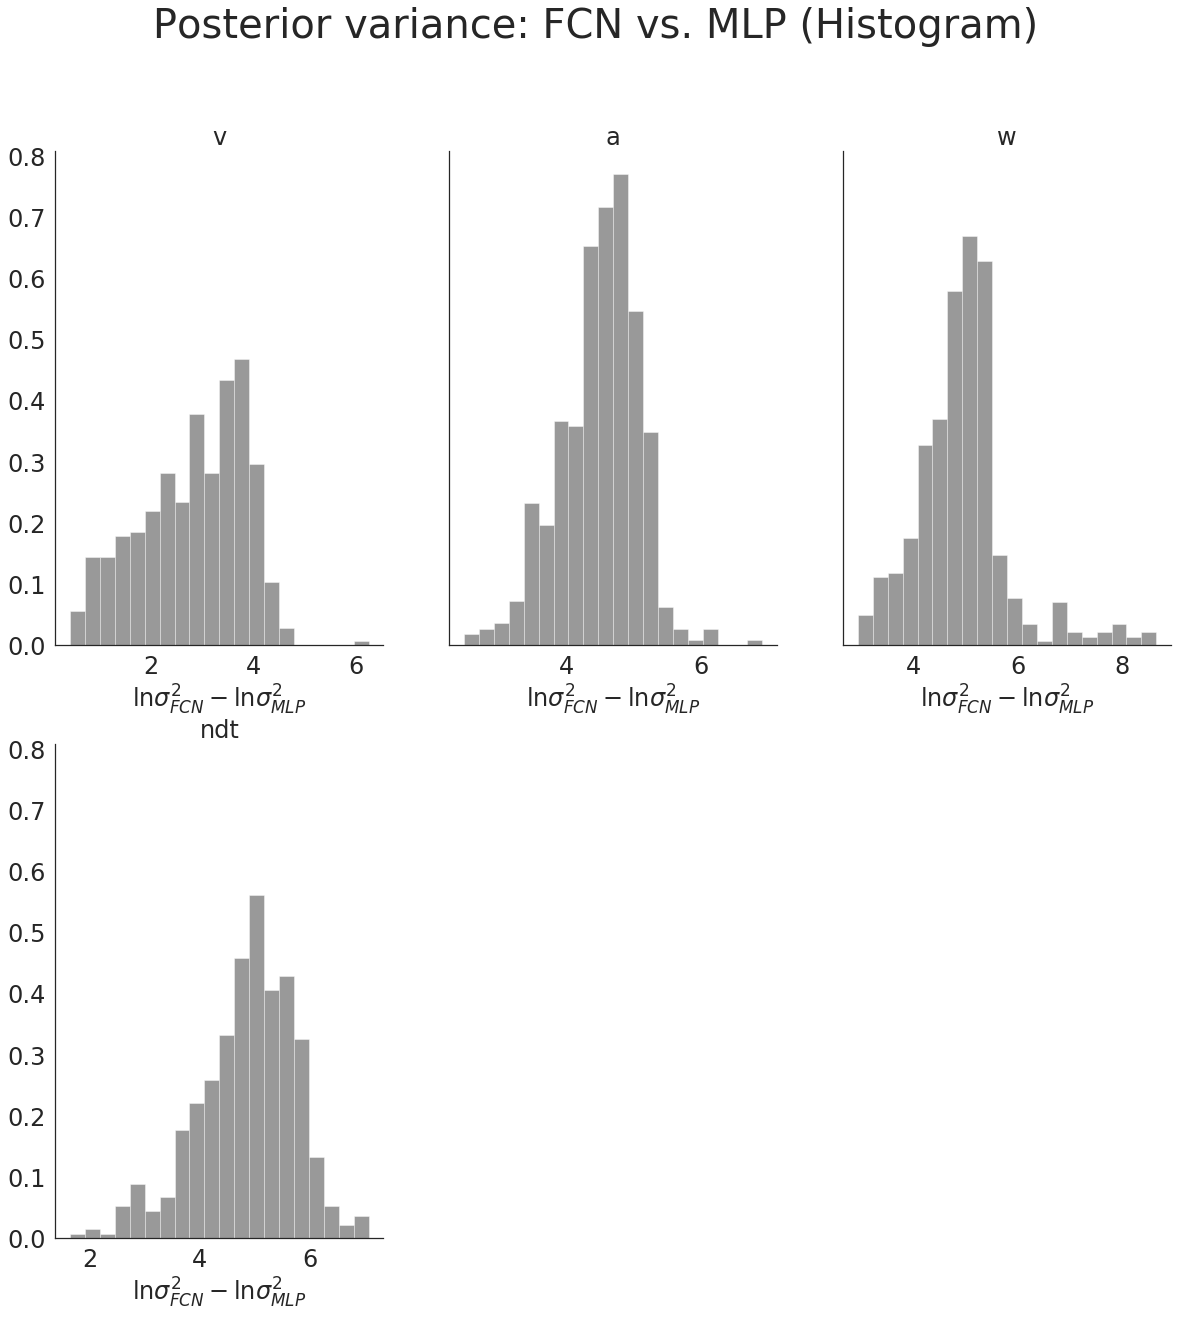

In [785]:
# Posterior variance Histograms: FCN vs. MLP
posterior_variance_comparison_hist(var_data_1 = deep_inference_var,
                                   var_data_2 = mlp_var,
                                   var_data_1_title = 'FCN',
                                   var_data_2_title = 'MLP',
                                   ax_titles = ax_titles_ddm)

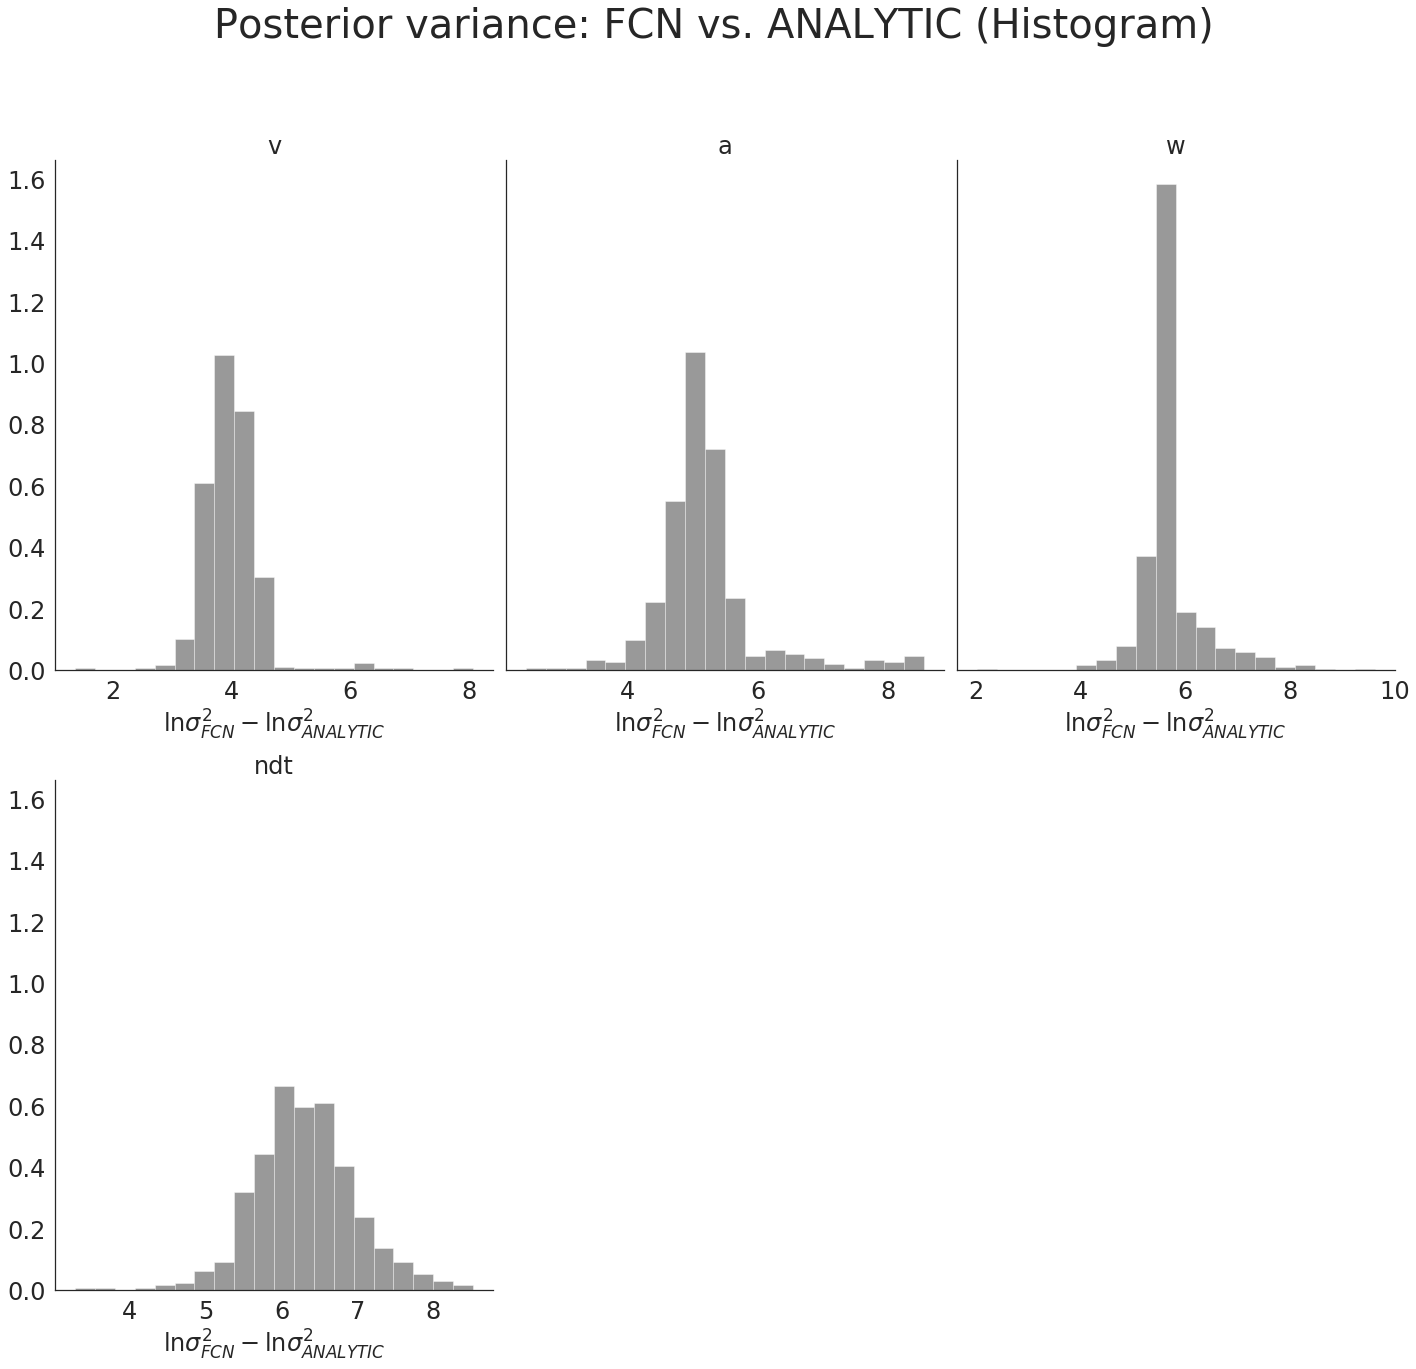

In [855]:
# Posterior variance Histograms: FCN vs. ANALYTIC
posterior_variance_comparison_hist(var_data_1 = deep_inference_var,
                                   var_data_2 = analytic_var,
                                   var_data_1_title = 'FCN',
                                   var_data_2_title = 'ANALYTIC',
                                   ax_titles = ax_titles_ddm)

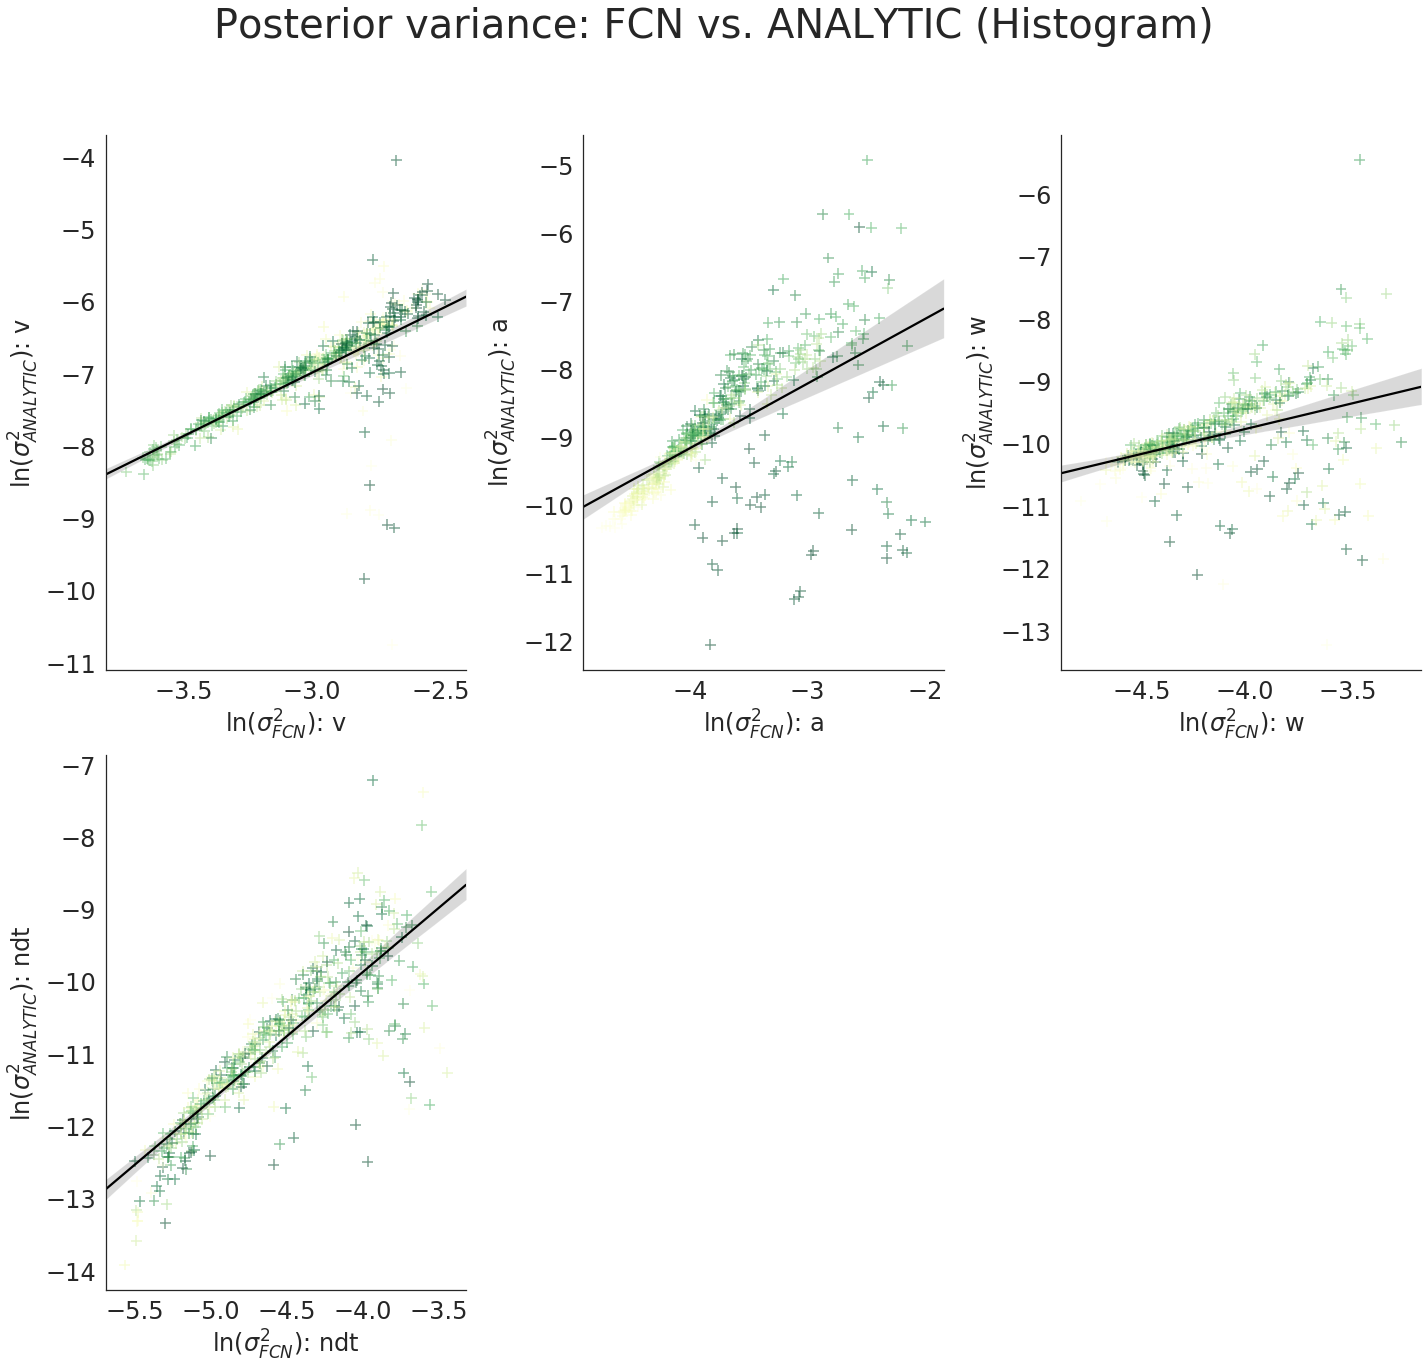

In [795]:
# POSTERIOR VARIANCE REGRESSION: FCN vs. ANALYTIC
posterior_variance_comparison_reg(var_data_1 = deep_inference_var,
                                      var_data_2 = analytic_var,
                                      params = dat_total[0], # need params here because we used normalize params to color graphs
                                      var_data_1_title = 'FCN',
                                      var_data_2_title = 'ANALYTIC',
                                      ax_titles = ax_titles_ddm,
                                      cols = 3)

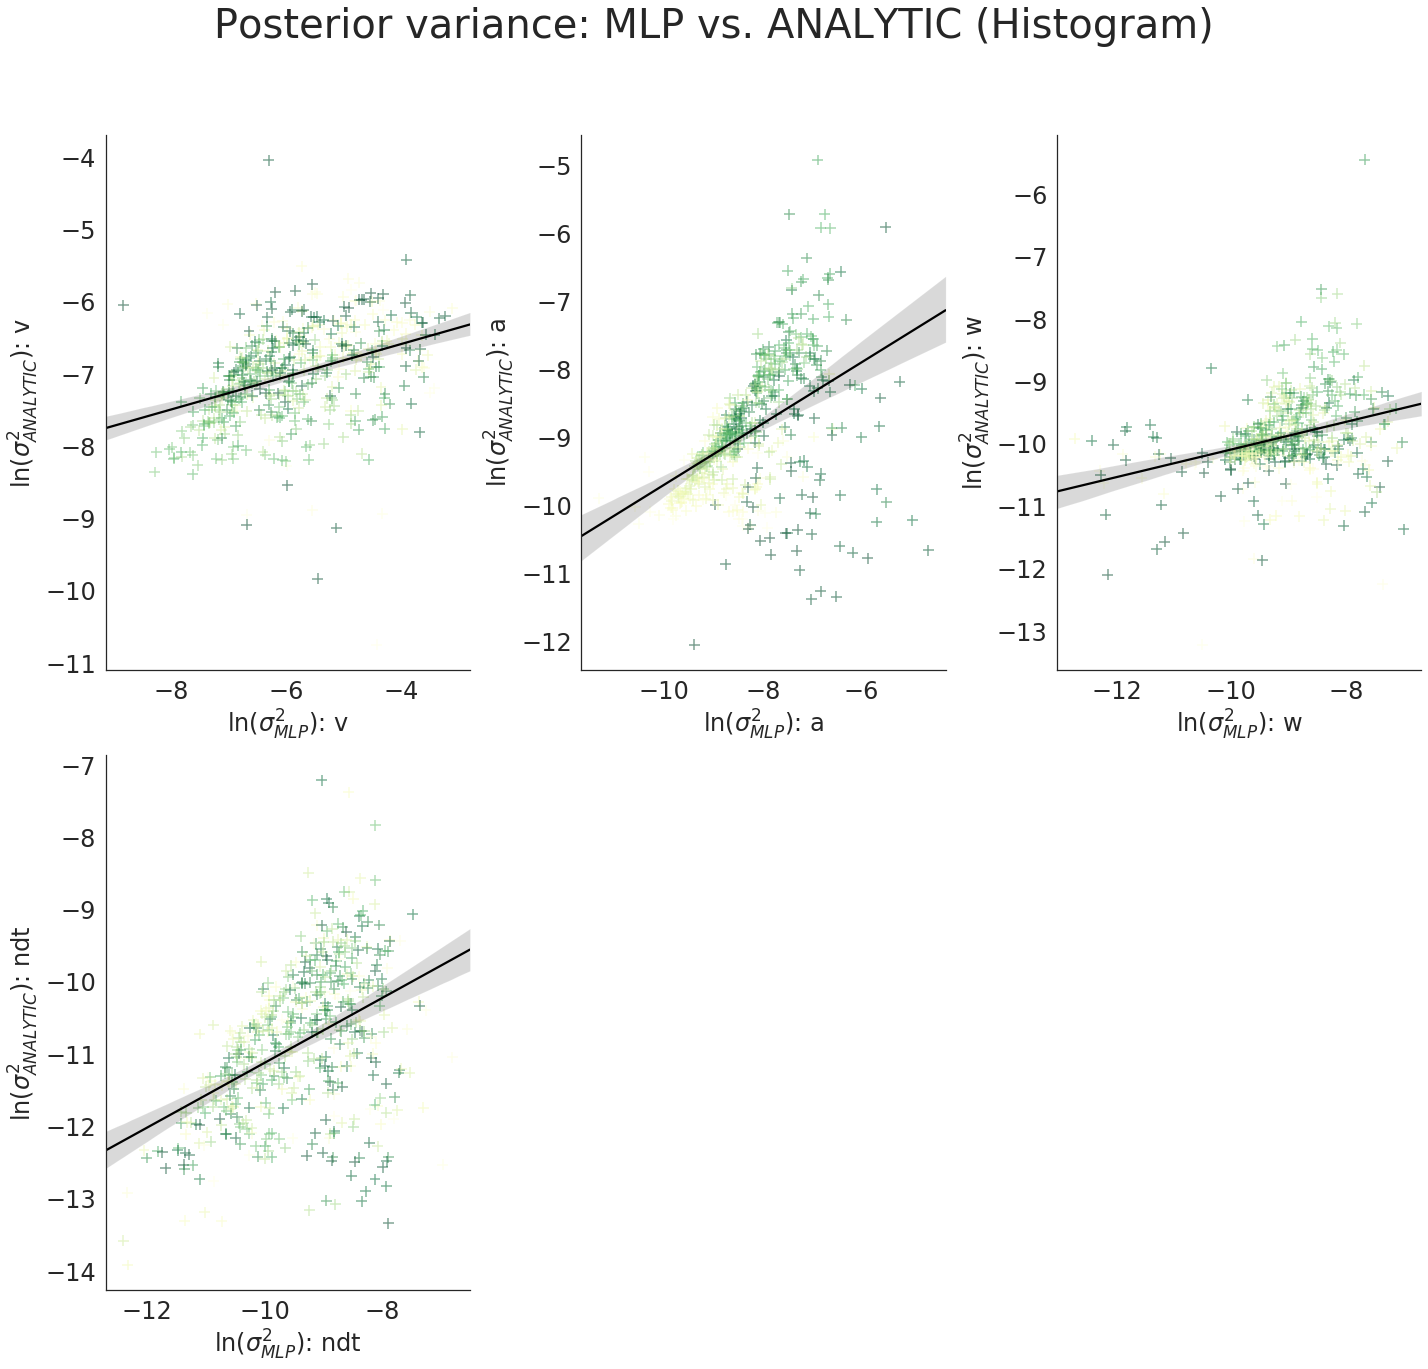

In [796]:
# POSTERIOR VARIANCE REGRESSION: MLP vs. ANALYTIC
posterior_variance_comparison_reg(var_data_1 = mlp_var,
                                  var_data_2 = analytic_var,
                                  params = dat_total[0], # need params here because we used normalize params to color graphs
                                  var_data_1_title = 'MLP',
                                  var_data_2_title = 'ANALYTIC',
                                  ax_titles = ax_titles_ddm,
                                  cols = 3)

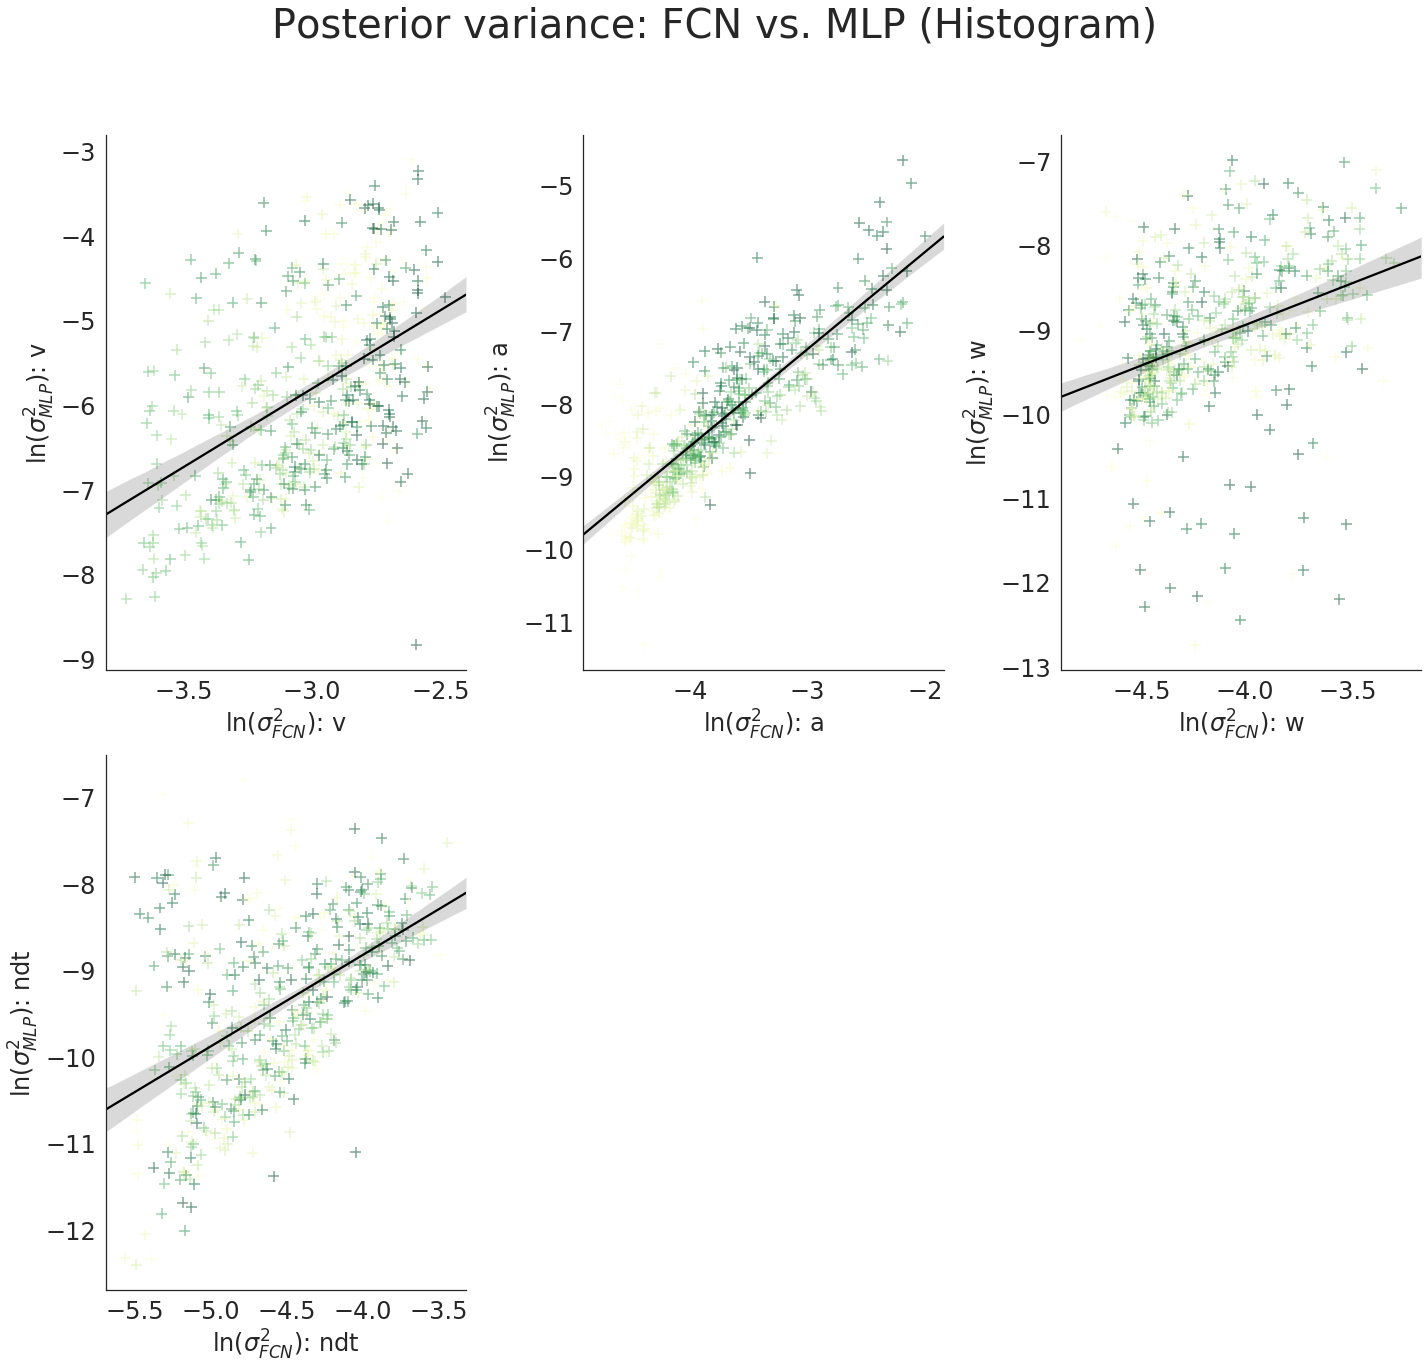

In [797]:
# POSTERIOR VARIANCE REGRESSION: FCN vs. MLP
posterior_variance_comparison_reg(var_data_1 = deep_inference_var,
                                  var_data_2 = mlp_var,
                                  params = dat_total[0], # need params here because we used normalize params to color graphs
                                  var_data_1_title = 'FCN',
                                  var_data_2_title = 'MLP',
                                  ax_titles = ax_titles_ddm,
                                  cols = 3)

In [ ]:
# UNUSED 
# SINGLE PLOTS OF INTEREST
fig, ax = plt.subplots(1, 1, 
                       figsize = (10, 10), 
                       sharex = False, 
                       sharey = False)

grayscale_map = plt.get_cmap('YlGn')

plt.scatter(dat_total[0][:, 5], means[:, 5],
            c = dat_total[0][:, 3],
            cmap = grayscale_map,
            alpha = 1)
ax.set_xlabel(ax_titles[i] + ' - ground truth', 
                                    fontsize = 24);
ax.set_ylabel(ax_titles[i] + ' - posterior mean', 
                                fontsize = 24);

cbar = plt.colorbar()
cbar.set_label(ax_titles[3], size = 24)
plt.show()

In [803]:
param_grid = np.random.uniform(low = [1, 2, 3], 
                               high = [2, 3, 5],
                               size = (1, 3))

In [807]:
param_grid

array([[1.6313942 , 2.20965826, 3.54153487]])

In [810]:
t = pd.DataFrame(np.zeros((10, 3)), columns = ['a', 'b', 'c'])

In [815]:
t.loc[0, :] = [1, 2, 3]

In [816]:
t

,a,b,c
0,1.0,2.0,3.0
1,0.0,0.0,0.0
2,0.0,0.0,0.0
3,0.0,0.0,0.0
4,0.0,0.0,0.0
5,0.0,0.0,0.0
6,0.0,0.0,0.0
7,0.0,0.0,0.0
8,0.0,0.0,0.0
9,0.0,0.0,0.0


In [819]:
arr = np.array([[1,2,3], [1,2,3]])

In [820]:
tuple(map(tuple, arr))

((1, 2, 3), (1, 2, 3))

In [825]:
tuple(map(tuple, np.random.uniform(low = [1, 2, 3],
                  high = [3, 4, 5],
                  size = (100, 3))))[0]

(2.8430377413650514, 3.7794642365610667, 4.534119505439818)

In [853]:
deep_inference_var

array([[0.07097156, 0.11066924, 0.03639958, 0.01265013],
       [0.06805368, 0.08660132, 0.03923214, 0.0288831 ],
       [0.05790914, 0.03538211, 0.02010234, 0.01639068],
       ...,
       [0.07479575, 0.05602723, 0.02377233, 0.00609172],
       [0.0764828 , 0.02409183, 0.01859565, 0.00506629],
       [0.06556254, 0.0184097 , 0.01523982, 0.00746852]], dtype=float32)

In [90]:
# BG Data Weibull
fold = '/media/data_cifs/afengler/data/kde/weibull_cdf/method_comparison/'
files_ = os.listdir(fold)
data_weibull = []
meta_weibull = pickle.load(open('/media/data_cifs/afengler/data/real/bg_stn_sampling_ready.pickle', 'rb'))
for file_ in files_:
    if "bg_stn_posterior" in file_:
        print(file_)
        data_weibull.append(pickle.load(open(fold + file_, 'rb'))[2])
        
data_weibull_new = np.zeros((6, 25, 10000, 6))
for i in range(data_new.shape[1]):
    data_weibull_new[:, i, :, :] = data_[i]
means_weibull = np.mean(data_new[:, :, 5000:, :], axis = 2)


# BG Data Angle
fold = '/media/data_cifs/afengler/data/kde/angle/method_comparison/'
files_ = os.listdir(fold)
data_angle = []
meta_angle = pickle.load(open('/media/data_cifs/afengler/data/real/bg_stn_sampling_ready.pickle', 'rb'))
for file_ in files_:
    if "bg_stn_posterior" in file_:
        print(file_)
        data_angle.append(pickle.load(open(fold + file_, 'rb'))[2])
        
data_angle_new = np.zeros((6, 25, 10000, 5))
for i in range(data_angle_new.shape[1]):
    data_angle_new[:, i, :, :] = data_angle[i]
means_angle = np.mean(data_angle_new[:, :, 5000:, :], axis = 2)


bg_stn_posterior_samples_10.pickle
bg_stn_posterior_samples_9.pickle
bg_stn_posterior_samples_6.pickle
bg_stn_posterior_samples_13.pickle
bg_stn_posterior_samples_14.pickle
bg_stn_posterior_samples_16.pickle
bg_stn_posterior_samples_12.pickle
bg_stn_posterior_samples_23.pickle
bg_stn_posterior_samples_3.pickle
bg_stn_posterior_samples_8.pickle
bg_stn_posterior_samples_17.pickle
bg_stn_posterior_samples_19.pickle
bg_stn_posterior_samples_18.pickle
bg_stn_posterior_samples_22.pickle
bg_stn_posterior_samples_15.pickle
bg_stn_posterior_samples_7.pickle
bg_stn_posterior_samples_24.pickle
bg_stn_posterior_samples_5.pickle
bg_stn_posterior_samples_1.pickle
bg_stn_posterior_samples_11.pickle
bg_stn_posterior_samples_4.pickle
bg_stn_posterior_samples_20.pickle
bg_stn_posterior_samples_2.pickle
bg_stn_posterior_samples_25.pickle
bg_stn_posterior_samples_21.pickle
bg_stn_posterior_samples_10.pickle
bg_stn_posterior_samples_9.pickle
bg_stn_posterior_samples_6.pickle
bg_stn_posterior_samples_13.pic

In [91]:
# SUPPORT FUNCTIONS GRAPHS
def bgn_posterior_plot(ax_titles = ['v', 'a', 'w', 'ndt', 'alpha', 'beta'], 
                            title = 'BG-STN: PARAMETER RECOVERY WEIBULL',
                            x_labels = [],
                            data = [],
                            cols = 3):
    
    rows = int(np.ceil(len(ax_titles) / cols))

    sns.set(style = "white", 
            palette = "muted", 
            color_codes = True)

    fig, ax = plt.subplots(rows, cols, 
                           figsize = (20, 20), 
                           sharex = False, 
                           sharey = False)
    fig.suptitle(title, fontsize = 40)

    sns.despine(right = True)

    for i in range(data.shape[2]):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        sns.set(style="whitegrid")
        sns.violinplot(data = data[:, :, i].T,
                       ax = ax[row_tmp, col_tmp])
#         ax[row_tmp, col_tmp].set_xlabel(ax_titles[i] + ' - ground truth', 
#                                         fontsize = 24);
        ax[row_tmp, col_tmp].set_ylabel(ax_titles[i] + ' - posterior mean', 
                                        fontsize = 24);
        ax[row_tmp, col_tmp].tick_params(axis = "x", 
                                         labelsize = 24)
        ax[row_tmp, col_tmp].set_xticklabels(x_labels, size = 14)
        #ax[row_tmp, col_tmp].set_yticklabels(size = 20)
    for i in range(data.shape[1], rows * cols, 1):
        row_tmp = int(np.floor(i / cols))
        col_tmp = i - (cols * row_tmp)
        ax[row_tmp, col_tmp].axis('off')

    #plt.setp(ax, yticks = [])
    return plt.show()

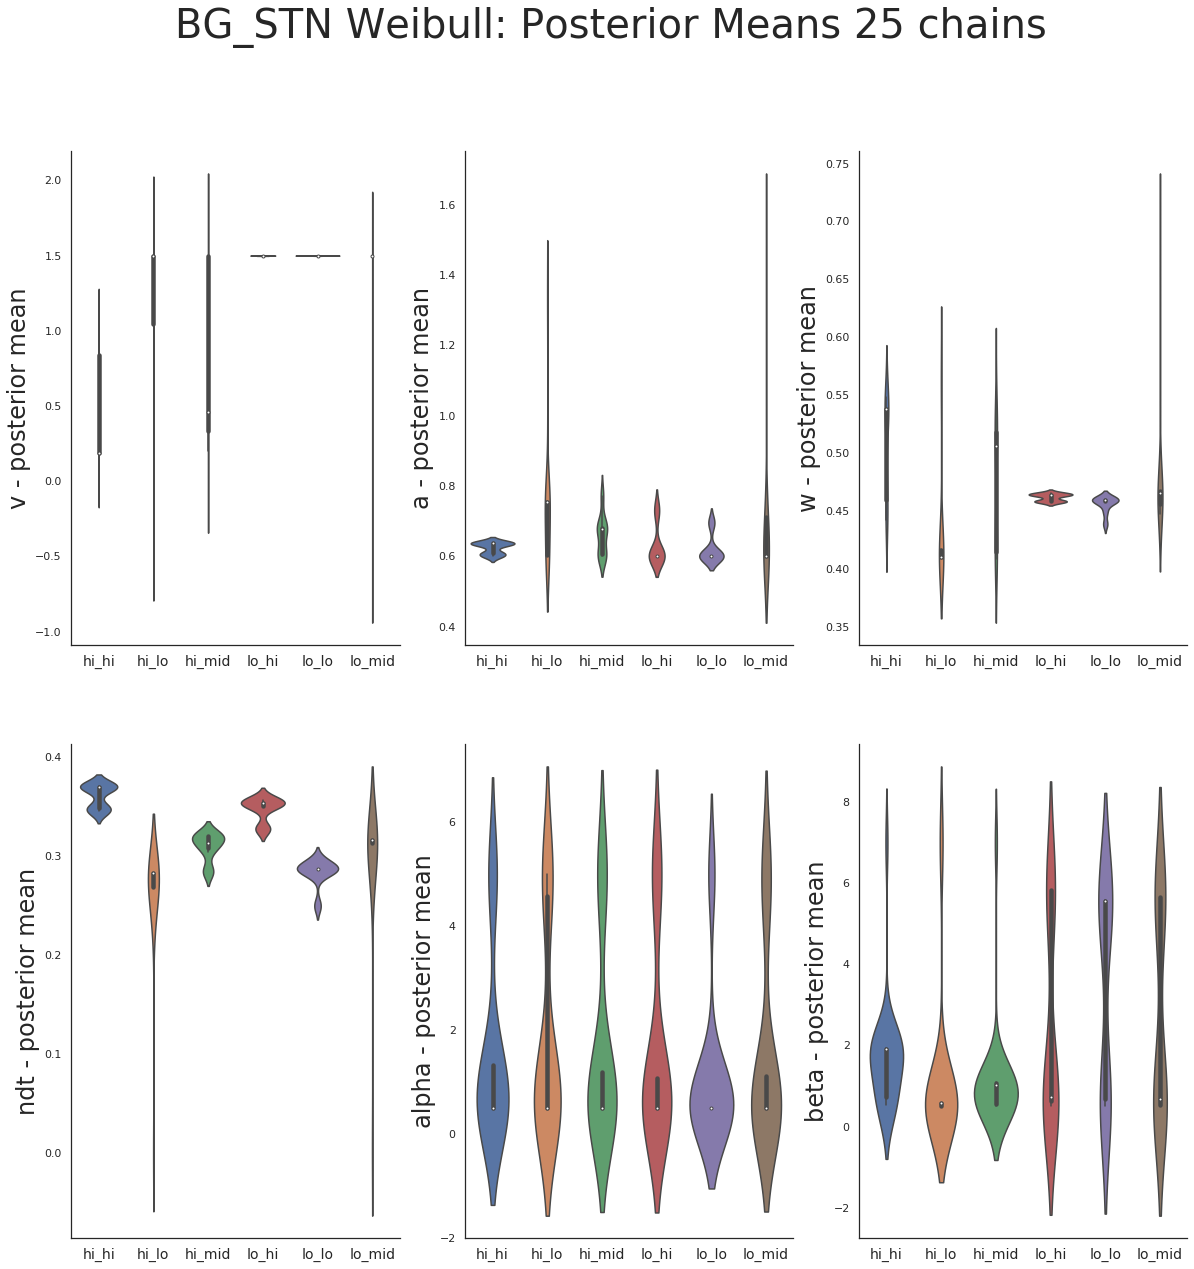

In [92]:
meta_[1]
x_labels = ['hi_hi', 'hi_lo', 'hi_mid', 'lo_hi', 'lo_lo', 'lo_mid']
bgn_posterior_plot(title = 'BG_STN Weibull: Posterior Means 25 chains',
                   ax_titles = ['v', 'a', 'w', 'ndt', 'alpha', 'beta'], 
                   data = means_weibull,
                   x_labels = x_labels)

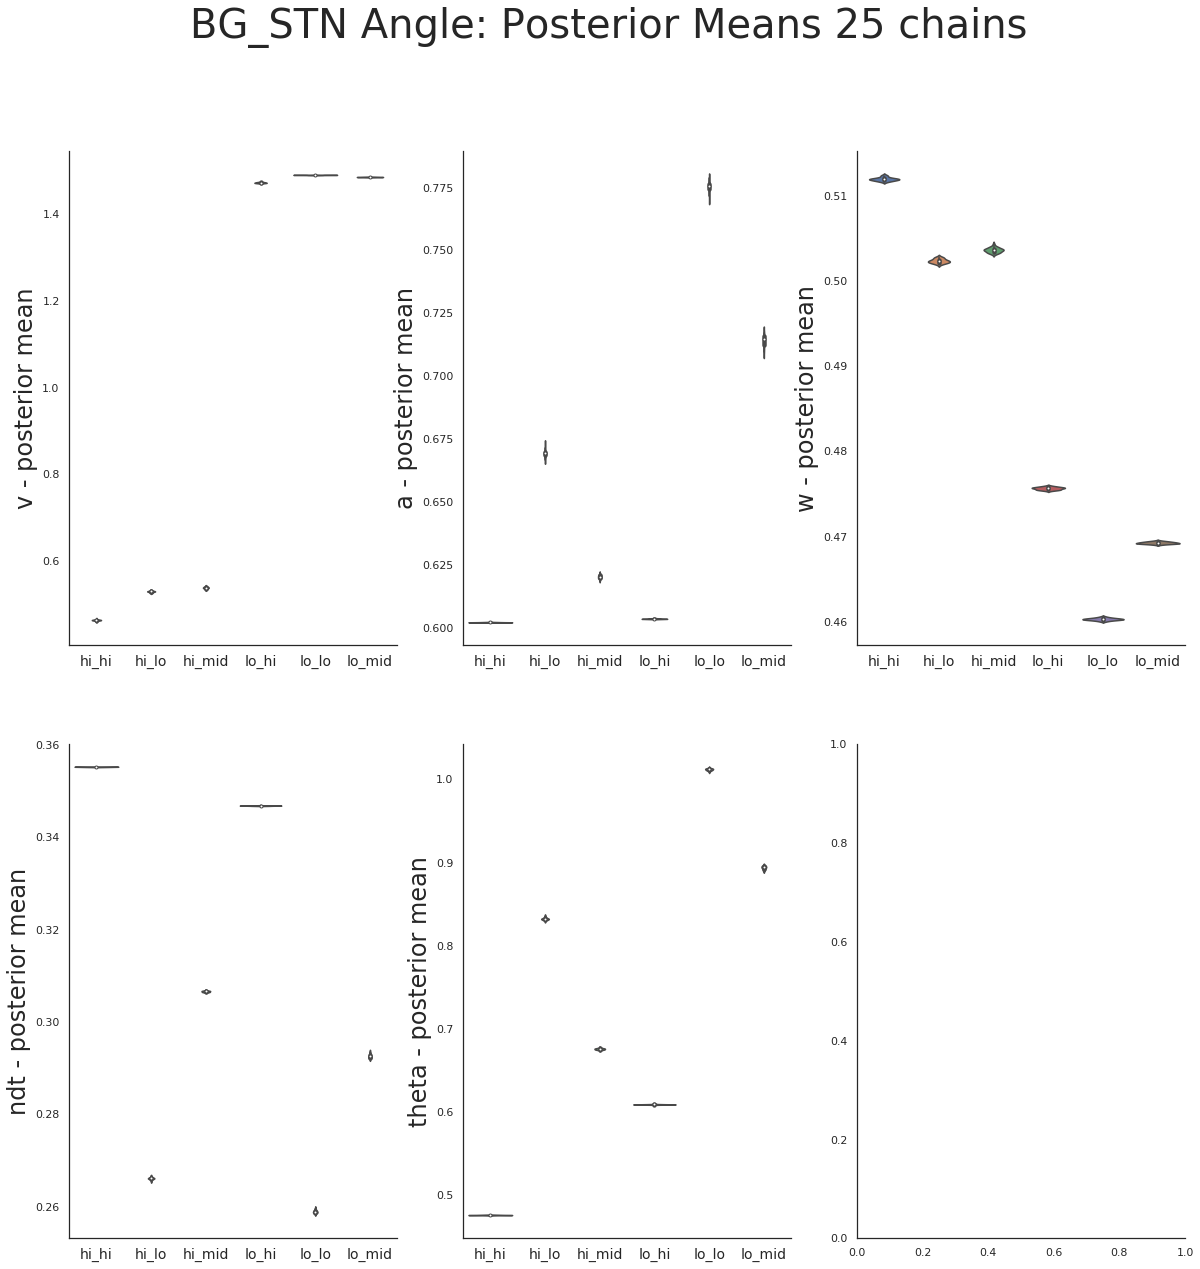

In [93]:
meta_[1]
x_labels = ['hi_hi', 'hi_lo', 'hi_mid', 'lo_hi', 'lo_lo', 'lo_mid']
bgn_posterior_plot(title = 'BG_STN Angle: Posterior Means 25 chains',
                   ax_titles = ['v', 'a', 'w', 'ndt', 'theta'], 
                   data = means_angle,
                   x_labels = x_labels)

In [95]:
meta_[1]

['hiconf_go_stnhi.txt',
 'hiconf_go_stnlo.txt',
 'hiconf_go_stnmid.txt',
 'loconf7_go_stnhi.txt',
 'loconf7_go_stnlo.txt',
 'loconf7_go_stnmid.txt']